In [41]:
import sys
print(sys.version)

3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:21:09) 
[Clang 9.0.1 ]


In [42]:
"""
Created on March 2 2021
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

In [43]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [44]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [45]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
from Residual_1D_module import * 
from Zernike_Analysis_Module import *

# 0.35d or greater

print('Zernike_Module.__version__: '+str(Zernike_Module.__version__))
print('Zernike_Analysis_Module.__version__: '+str(Zernike_Analysis_Module.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Zernike_Module.__version__: 0.41c
Zernike_Analysis_Module.__version__: 0.26g


In [46]:
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle
import glob
import time

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

from astropy.io import fits

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c



print(np.__version__)
print(skimage.__version__)
print(scipy.__version__)
print(pd.__version__)

1.18.5
0.17.2
1.5.0
1.0.5


# Unit test 

In [237]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((20,20))
var_image_unit=np.ones((20,20))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([7.1,1.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,verbosity=0,npix=1536)   

res=model(allparameters_proposal,return_Image=True)


print(res[0])

version of the code is: 0.41
-367.5754132818689


/Users/nevencaplar/Documents/PFS/PFS_Work_In_Progress/Zernike_Module.py:4257: RankWarning: Polyfit may be poorly conditioned
  custom_var_image=self.create_custom_var(modelImg,sci_image,var_image,mask_image)
/Users/nevencaplar/anaconda2/envs/idp2_pyfftw/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [238]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')



res_iapetus=res[1]

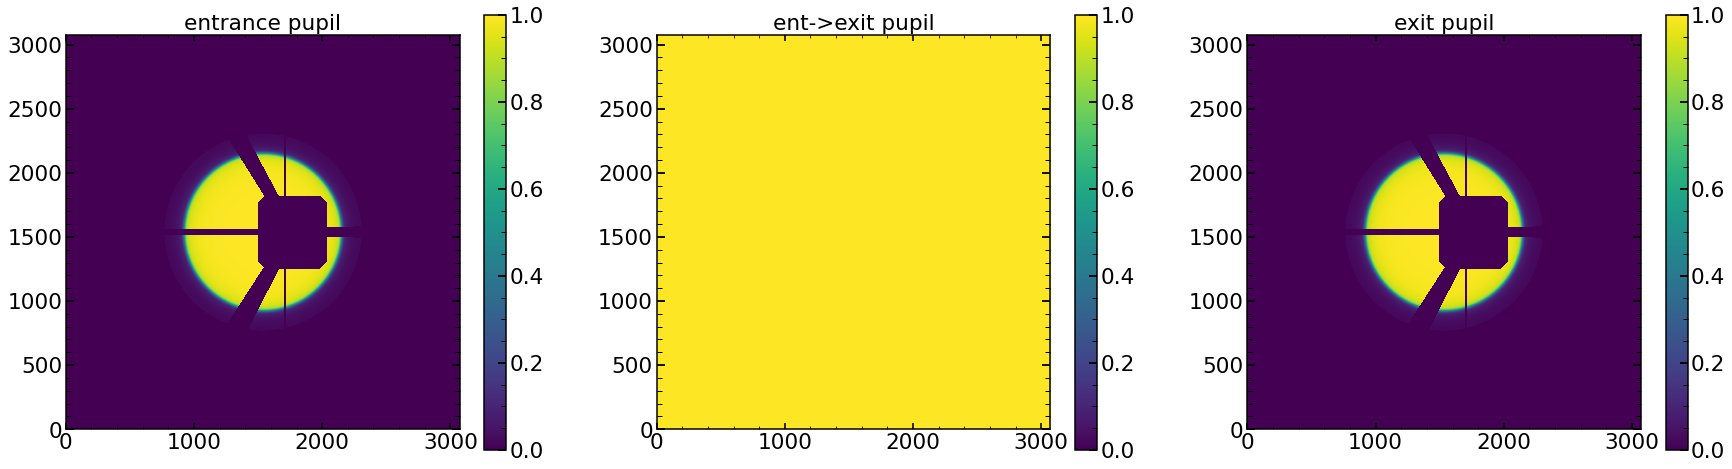

In [239]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

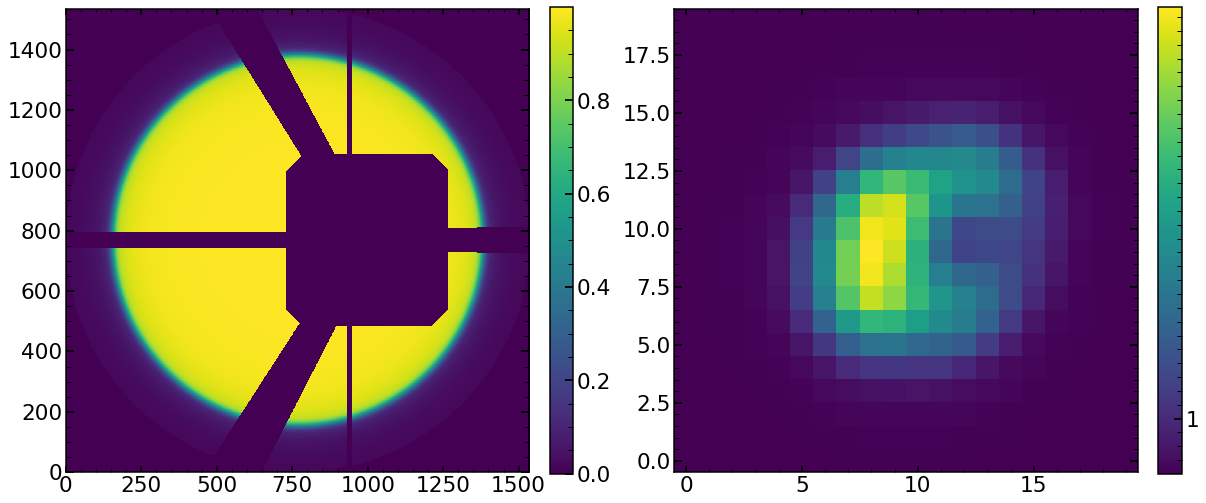

In [240]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
plt.imshow(res_iapetus,origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10**-2,1,10,10**2,10**3,10**4,10**5])

# Images for Michael/poster

## good recent image 

In [8]:
import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
from Residual_1D_module import * 
from Zernike_Analysis_Module import *


In [9]:
DATAFRAMES_FOLDER='/Users/nevencaplar/Documents/PFS/Fit_Results/Jan2921/'

with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ar_from_Jan2921.pkl', 'rb') as f:
    results_of_fit_many_Ar_from_Jan29=pickle.load(f)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ne_from_Jan2921.pkl', 'rb') as f:
    results_of_fit_many_Ne_from_Jan29=pickle.load(f)    
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Kr_from_Jan2921.pkl', 'rb') as f:
    results_of_fit_many_Kr_from_Jan29=pickle.load(f)    

In [10]:
index_Ar=results_of_fit_many_Ar_from_Jan29['0'].index[np.log10(results_of_fit_many_Ar_from_Jan29['0']['chi2'].values/results_of_fit_many_Ar_from_Jan29['0']['chi2max'].values)==np.min(np.log10(results_of_fit_many_Ar_from_Jan29['0']['chi2'].values/results_of_fit_many_Ar_from_Jan29['0']['chi2max'].values))][0]
results_of_fit_many_Ar_from_Jan29['0'].loc[index_Ar]

z4             0.583624
z5             0.096308
z6             0.091398
z7             0.263171
z8             0.320398
               ...     
z54            0.001800
z55            0.005206
z56           -0.002941
chi2          25.140766
chi2max    26446.005859
Name: 17, Length: 78, dtype: float64

In [11]:
np.log10(results_of_fit_many_Ne_from_Jan29['0']['chi2'].values/results_of_fit_many_Ne_from_Jan29['0']['chi2max'].values)

array([-3.00806192, -2.66874003, -3.06738118, -3.10539325, -3.07116454,
       -2.47254036, -3.31791156, -2.77754443, -2.52807131, -2.89038856,
       -2.72517208, -2.74621489, -2.87233488, -2.55855649, -1.82500239,
       -2.69025609, -2.96441311, -2.70881825, -2.97735303, -2.38059773,
       -2.87933653, -2.93894102, -2.77901462, -2.86100907, -2.77652329,
       -3.11103935, -2.99384834, -2.92132949, -2.8154349 , -2.93036988,
       -2.40417206, -2.78181689, -2.84983238, -2.90295593, -2.37601667,
       -2.11284027, -2.8314205 , -2.86290834, -2.846861  , -2.95046778,
       -2.71094695, -3.07814674, -2.71701931, -2.9773274 , -2.83557419,
       -3.34638737, -2.97153558, -2.85914061, -2.96428887, -2.793518  ])

In [12]:
np.log10(results_of_fit_many_Kr_from_Jan29['0']['chi2'].values/results_of_fit_many_Kr_from_Jan29['0']['chi2max'].values)

array([-2.71640177, -2.6311193 , -2.60856308, -2.39812688, -2.61168323,
       -2.56562577, -2.64008286, -2.31350847, -2.56144452, -2.6611007 ,
       -2.5859382 , -2.31712543, -2.4566981 , -2.67333607, -2.67230274,
       -2.66437244, -2.37495001, -2.57205723, -2.24582693, -2.38324195,
       -2.62279973, -2.41937831, -2.62530361, -2.75398965, -2.49577041,
       -2.25643948, -2.58337808, -2.62238771, -2.34785296, -2.75781324,
       -2.66276193, -2.53174245, -2.2918885 , -2.45378403, -2.81628106])

In [13]:
finalAr=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalAr_Feb2020",allow_pickle=True)
finalNe=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalNe_Feb2020",allow_pickle=True)
finalKr=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalKr_Feb2020",allow_pickle=True)

In [14]:
date='Jan2920'
#obs=34313
#obs_int=int(obs)
single_number='17'
image_index=int(single_number)
eps=6
arc='Ar'
dataset=6

if arc=='Ar':
    obs=34341+96
    finalArc=finalAr
if arc=='Ne':
    obs=34217+96 
    finalArc=finalNe
if arc=='Kr':
    obs=34561+96
    finalArc=finalKr



list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

finalArc.loc[int(single_number)]

fiber                    63
xc                      463
yc                     1631
wavelength        763.74286
close                     1
lamp                     Ar
xc_effective            463
second_offset             0
second_ratio              0
second2_offset            0
second2_ratio             0
Name: 17, dtype: object

STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: 0
self.single_number: 17
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34389
double_sources_positions_ratios for this spot is: [0.0 0.0]


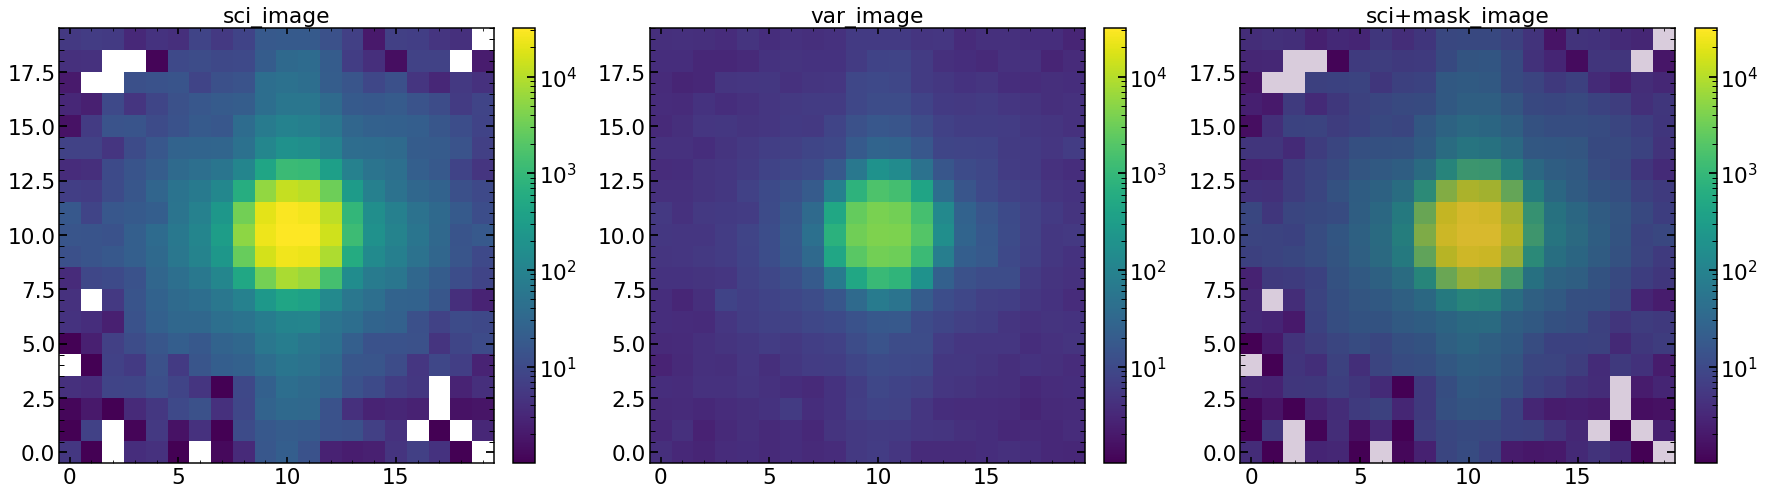

In [15]:
single_analysis=Zernike_Analysis(date=date,obs='0',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                 list_of_defocuses=list_of_defocuses_input_long)
single_analysis.create_basic_data_image()

In [16]:
double_sources,double_sources_positions_ratios=single_analysis.return_double_sources()
list_of_sci_images,list_of_var_images,list_of_mask_images=single_analysis.return_lists_of_images()
index_of_single_image=single_analysis.return_index_of_single_image_in_list_of_images()
columns,columns22,columns22_analysis=single_analysis.return_columns()

chain0_swarm_1,likechain0_swarm_1=single_analysis.create_chains_swarm_1()
#chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain_parametrization,like_min=single_analysis.create_likelihood()

Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Jan2920/chainJan2920_Single_P_34437176ArSwarm1.npy
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Jan2920/chainJan2920_Single_P_34437176ArSwarm1.npy
(36, 480, 129)
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Jan2920/chainJan2920_Single_P_34437176ArSwarm1.npy
(36, 480, 129)
minimal likelihood is: 4122.876157844915
average chi2 reduced is: 24.2922622090499


In [26]:
index_of_single_image=4

model_multi=LN_PFS_multi_same_spot(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=1,zmax=56,verbosity=1,\
                      double_sources=double_sources,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=False)   

#list_of_minchain=model_multi.create_list_of_allparameters(t1,list_of_defocuses=list_of_defocuses_input_long,zmax=56)
list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=list_of_defocuses_input_long,zmax=56)


model = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],dithering=1,save=1,zmax=22,verbosity=1,\
                      double_sources=None,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)  

res_with_Image=model(list_of_minchain[index_of_single_image],return_Image=True)

Science image shape is: (20, 20)
Top left pixel value of the science image is: 5.3227744
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 3.9924357
Mask image shape is: (20, 20)
Sum of mask image is: 0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.41a
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22

Entering lnlike_Neven
allparameters [     0.58362374      0.09630755      0.09139815      0.26317125
      0.32039777     -0.03798492     -0.24393043     -0.26068724
     -0.12436885     -0.04368618      0.00261616      0.03377038
     -0.01841272      0.01998359      0.00523577      0.00619805
     -0.01447286      0.03254536      0.01453803      0.66804131
      0.08945204     -0.14769607      0.00216925      0.05676446
      0.03591548      0.1134056       0.08830516      0.
   

chi2 within shgo optimization routine (chi_2_almost_multi_values): [-5.22729337 -4.68853453] / 8.904398
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-5.23941131 -4.69154398] / 8.897454
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-5.24710148 -4.68605643] / 8.90652
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-5.23542056 -4.69147756] / 8.897242
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-5.23561479 -4.69522449] / 8.89779
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-5.23651536 -4.69336763] / 8.897149
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-5.23252461 -4.69330121] / 8.898526
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-5.23768964 -4.69198329] / 8.897061
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-5.23878444 -4.69387335] / 8.897443
chi2 within shgo optimization routine (chi_2_almost_multi_values):

In [27]:
sci_image=list_of_sci_images[index_of_single_image]
var_image=list_of_var_images[index_of_single_image]
res_iapetus=res_with_Image[1]



size=sci_image.shape[0]
#if size==40:
#    dithering=2
#else:
#    dithering=1
#dithering=1

if size==20:
    x_center=find_centroid_of_flux(res_iapetus)[0]
else:
    x_center=(size/2)

left_limit=np.round(x_center-3.5)+0.5
right_limit=np.round(x_center+3.5)-0.5               


plt.figure(figsize=(14,14))

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

In [28]:
init_lamda,std_init_lamda,init_removal_lamda,std_init_removal_lamda=residual_1D(sci_image,var_image,res_iapetus)

x_center=find_centroid_of_flux(res_iapetus)[0]  
left_limit=np.int(x_center-3.5)
right_limit=np.int(x_center+3.5) 
multiplicative_factor_to_renormalize_to_50000=np.max(sci_image)/50000
sci_image_smaller=sci_image[:,left_limit:right_limit]/multiplicative_factor_to_renormalize_to_50000
var_image_smaller=var_image[:,left_limit:right_limit]/multiplicative_factor_to_renormalize_to_50000

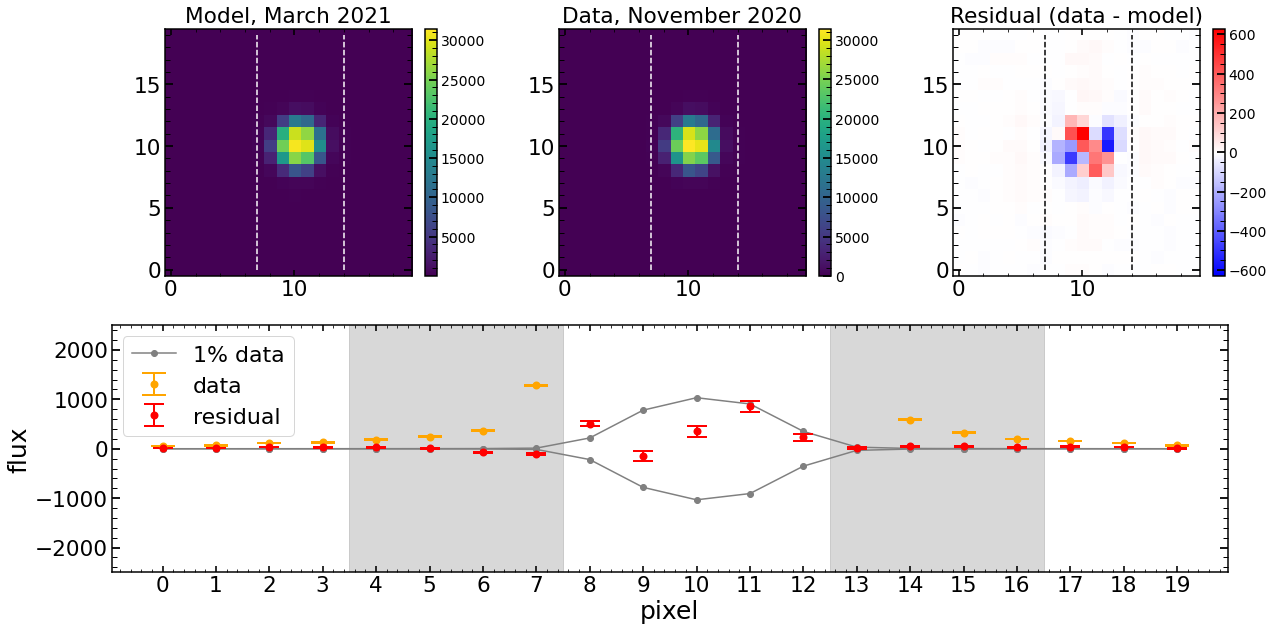

In [29]:
from matplotlib import gridspec
fig=plt.figure(figsize=(20,10))



ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0), colspan=3)


im1=ax1.imshow(res_iapetus,origin='lower',vmax=np.max(np.abs(sci_image)))
ax1.plot(np.ones(len(sci_image))*(left_limit+1),np.array(range(len(sci_image))),'--',color='white')
ax1.plot(np.ones(len(sci_image))*(right_limit+1),np.array(range(len(sci_image))),'--',color='white')
cb=fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04) 
cb.ax.tick_params(labelsize=14)
ax1.set_title('Model, March 2021')
#ax1.grid(False)



im2=ax2.imshow(sci_image,origin='lower',vmax=np.max(np.abs(sci_image)))
ax2.plot(np.ones(len(sci_image))*(left_limit+1),np.array(range(len(sci_image))),'--',color='white')
ax2.plot(np.ones(len(sci_image))*(right_limit+1),np.array(range(len(sci_image))),'--',color='white')
cb=fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04) 
cb.ax.tick_params(labelsize=14)
ax2.set_title('Data, November 2020')
ax2.grid(False)


im3=ax3.imshow(sci_image-res_iapetus,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image))/50,vmax=np.max(np.abs(sci_image))/50)
ax3.plot(np.ones(len(sci_image))*(left_limit+1),np.array(range(len(sci_image))),'--',color='black')
ax3.plot(np.ones(len(sci_image))*(right_limit+1),np.array(range(len(sci_image))),'--',color='black')
ax3.set_title('Residual (data - model)')
cb=fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04) 
cb.ax.tick_params(labelsize=14)

ax4.errorbar(np.array(range(len(init_lamda))),init_lamda,yerr=std_init_lamda,fmt='o',elinewidth=2,capsize=12,markeredgewidth=2,label='data',color='orange')
ax4.plot(np.array(range(len(init_lamda))),init_lamda*0.01,color='gray',label='1% data',marker='o')
ax4.plot(np.array(range(len(init_lamda))),-init_lamda*0.01,color='gray',marker='o')    
plt.errorbar(np.array(range(len(init_removal_lamda))),init_removal_lamda,yerr=std_init_removal_lamda,color='red',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='residual')

ax4.set_ylim(-2500,2500)
ax4.set_ylabel('flux',size=25)
ax4.set_xlabel('pixel',size=25)
ax4.set_xticks(range(20))
position_of_max_flux=np.where(init_lamda==np.max(init_lamda))[0][0]
difference_from_max=range(20)-position_of_max_flux
pixels_to_test=np.array(range(20))[(np.abs(difference_from_max)>2)&(np.abs(difference_from_max)<=6)]
plt.axvspan(pixels_to_test[0]-0.5, pixels_to_test[3]+0.5, alpha=0.3, color='grey')
plt.axvspan(pixels_to_test[4]-0.5, pixels_to_test[7]+0.5, alpha=0.3, color='grey')
plt.legend(loc=2, fontsize=22)

## good recent in defocus 

STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 17
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0.0 0.0]


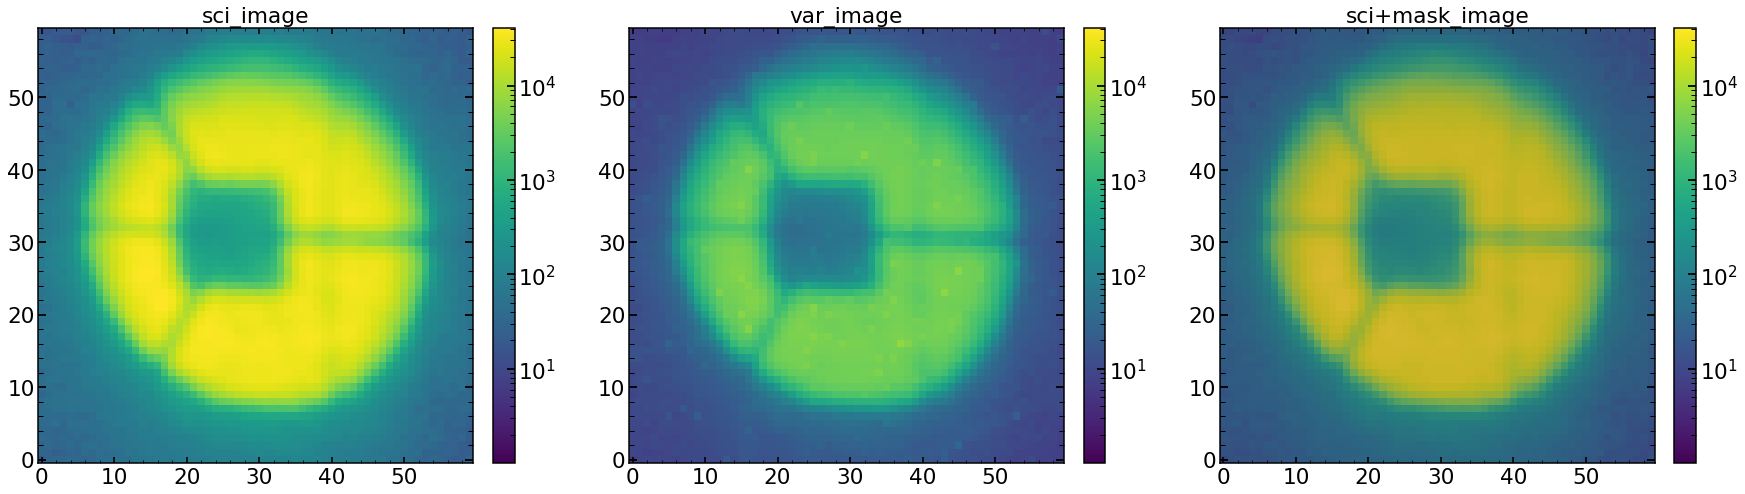

In [21]:
single_analysis=Zernike_Analysis(date=date,obs='m4',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                 list_of_defocuses=list_of_defocuses_input_long)
sci_image,var_image,mask_image=single_analysis.create_basic_data_image(return_Images=True)

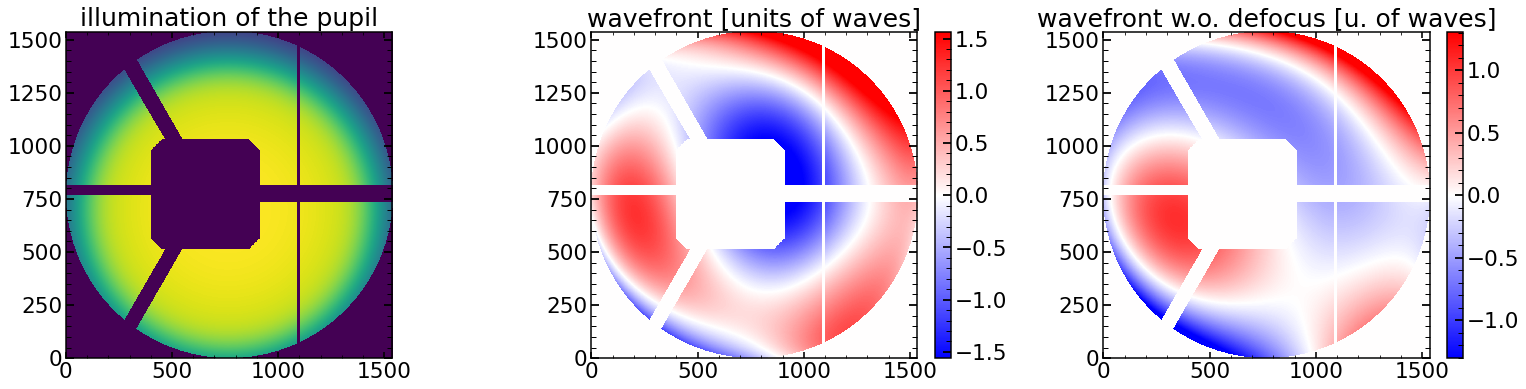

In [22]:
ilum_zoom,wavefront_zoom,wavefront_0_zoom  = single_analysis.illumination_wavefront_plot(return_Images=True)

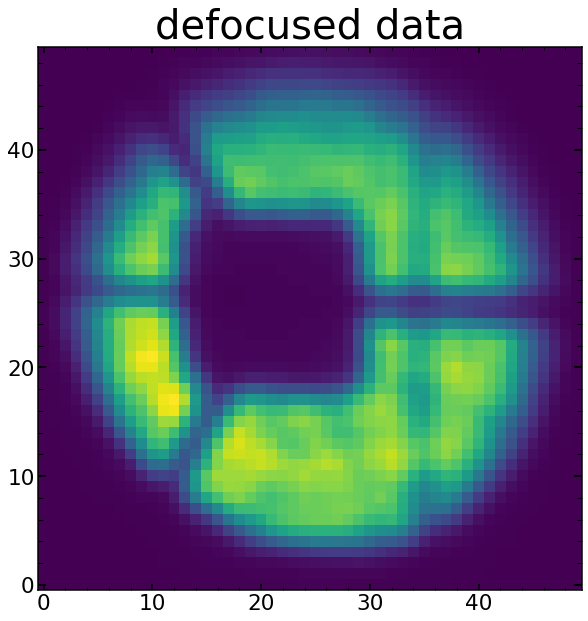

In [23]:
plt.figure(figsize=(10,10))
plt.title('defocused data',fontsize=40)
plt.imshow(sci_image[5:55,5:55],origin='lower',vmin=1,vmax=np.max(sci_image))

([], <a list of 0 Text major ticklabel objects>)

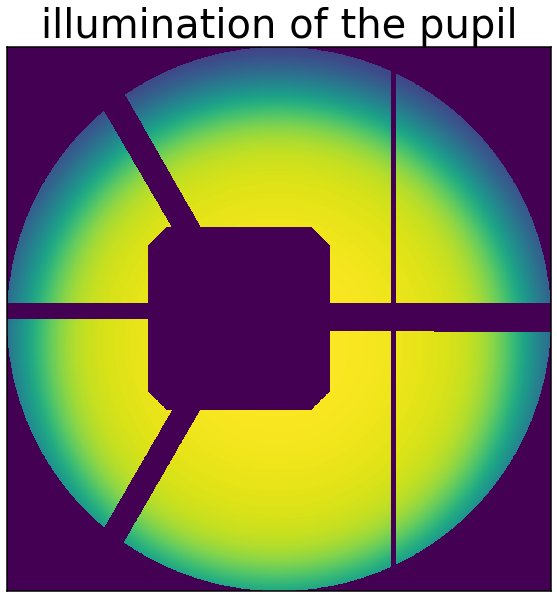

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(ilum_zoom,origin='lower',vmax=1,vmin=0)
plt.title('illumination of the pupil',fontsize=40)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

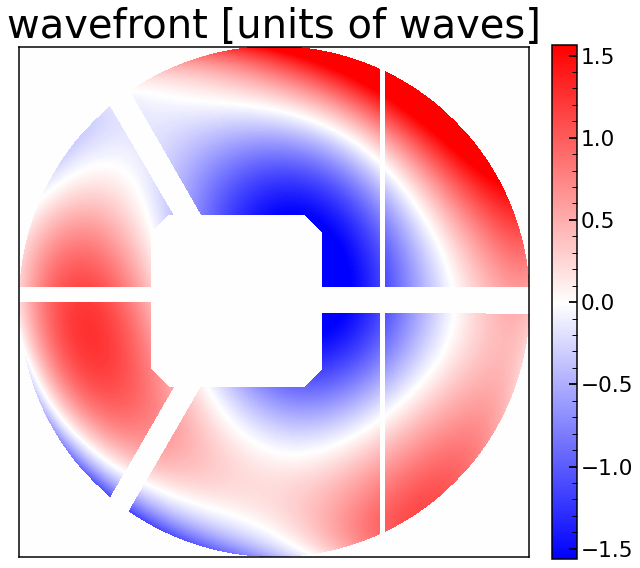

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(wavefront_zoom,origin='lower',cmap=plt.get_cmap('bwr'),vmax=np.max(np.abs(wavefront_zoom))*0.75,vmin=-np.max(np.abs(wavefront_zoom))*0.75)

plt.colorbar(fraction=0.046, pad=0.04)
plt.title('wavefront [units of waves]',fontsize=40)
plt.xticks([])
plt.yticks([])

In [ ]:
,return_Images=False

## Mar 06

In [12]:
import Zernike_Module_v028
import Zernike_Analysis_Module_022b
from Zernike_Module_v028 import *
from Residual_1D_module import * 
from Zernike_Analysis_Module_022b import *


In [13]:
sci_image_old =np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/sci2140017HgAr_Stacked.npy')
mask_image_old =np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/mask2140017HgAr_Stacked.npy')
var_image_old =np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/var2140017HgAr_Stacked.npy')

In [14]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr15_Focus/' + 'results_of_fit_many_direct_HgAr_from_Apr15.pkl', 'rb') as f:
    results_of_fit_many_direct_HgAr_from_Apr1520=pickle.load(f)

NameError: name 'pickle' is not defined

In [15]:
results_of_fit_many_direct_HgAr_from_Apr1520.loc[17]

NameError: name 'results_of_fit_many_direct_HgAr_from_Apr1520' is not defined

In [131]:
minchain=results_of_fit_many_direct_HgAr_from_Apr1520.loc[17].values[:-2]
minchain

array([    0.46899423,     0.04517438,     0.05840604,     0.31828815,
           0.35576521,    -0.01927996,    -0.27101619,    -0.23279941,
          -0.1362587 ,    -0.03562265,     0.01158498,     0.0240104 ,
          -0.01938301,     0.02229256,    -0.00209219,    -0.00587332,
          -0.0242157 ,     0.03498719,     0.0278716 ,     0.67830432,
           0.08879704,    -0.15143947,     0.0098843 ,     0.05526952,
           0.04301217,     0.0000172 ,     0.0000172 ,     0.97608598,
           0.94835579,     0.0045966 ,    -0.07158372,     0.92811379,
           0.07822675,     0.73715088,     1.00114411,     0.5091121 ,
       52199.86717144,     2.19374285,     0.00179639,     0.35000173,
           1.82131383,     0.99829198])

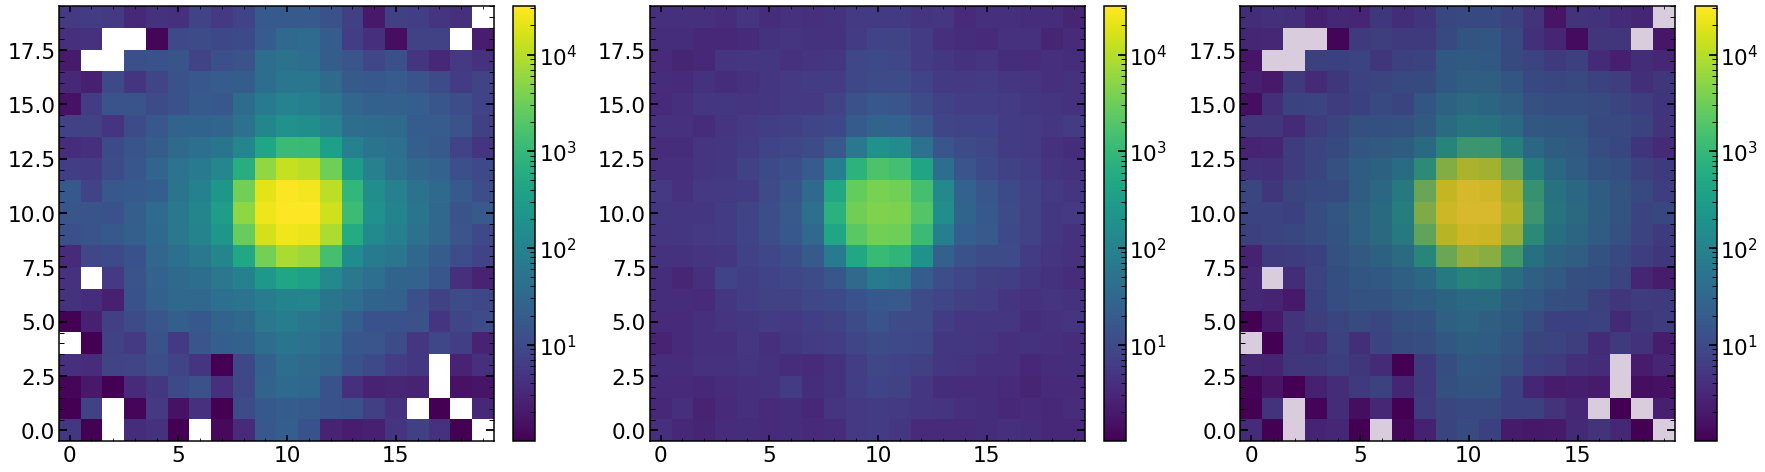

In [132]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(132)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(133)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(mask_image,origin='lower',vmin=0,vmax=np.max(mask_image),alpha=0.2)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
#cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [133]:
model = LN_PFS_single(sci_image,var_image,mask_image=mask_image,dithering=1,save=1,zmax=22,verbosity=1,\
                      double_sources=None,double_sources_positions_ratios=[0,0],npix=1536,simulation_00=0)   
#minchain_new=np.copy(minchain)   
#minchain_new[0]=10
#minchain_new[1]=5

model(minchain)

npix_value:1536
Science image shape is: (20, 20)
Top left pixel value of the science image is: 5.3227744
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 3.9924357
Mask image shape is: (20, 20)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22

Entering lnlike_Neven
allparameters [    0.46899423     0.04517438     0.05840604     0.31828815
     0.35576521    -0.01927996    -0.27101619    -0.23279941
    -0.1362587     -0.03562265     0.01158498     0.0240104
    -0.01938301     0.02229256    -0.00209219    -0.00587332
    -0.0242157      0.03498719     0.0278716      0.67830432
     0.08879704    -0.15143947     0.0098843      0.05526952
     0.04301217     0.0000172      0.0000172      0.97608598
     0.94835579     0.0045966     -0.07158372     0.92811379
     0.07822675     0.73715088     1.00114411  

-4633.744183951676

In [134]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut.npy')
optPsf_cut_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled.npy')
scattered_light=np.load(TESTING_FINAL_IMAGES_FOLDER+'scattered_light.npy')
optPsf_cut_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled_scattered.npy')
optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled


#optPsf_cut_grating_convolved_simulation_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')
#res_iapetus=optPsf_cut_grating_convolved_simulation_cut

In [135]:
minchain

array([    0.46899423,     0.04517438,     0.05840604,     0.31828815,
           0.35576521,    -0.01927996,    -0.27101619,    -0.23279941,
          -0.1362587 ,    -0.03562265,     0.01158498,     0.0240104 ,
          -0.01938301,     0.02229256,    -0.00209219,    -0.00587332,
          -0.0242157 ,     0.03498719,     0.0278716 ,     0.67830432,
           0.08879704,    -0.15143947,     0.0098843 ,     0.05526952,
           0.04301217,     0.0000172 ,     0.0000172 ,     0.97608598,
           0.94835579,     0.0045966 ,    -0.07158372,     0.92811379,
           0.07822675,     0.73715088,     1.00114411,     0.5091121 ,
       52199.86717144,     2.19374285,     0.00179639,     0.35000173,
           1.82131383,     0.99829198])

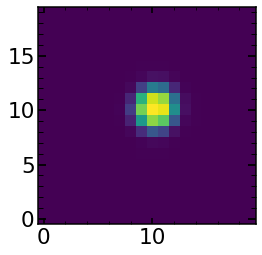

In [136]:
plt.imshow(res_iapetus)

In [137]:
init_lamda,std_init_lamda,init_removal_lamda,std_init_removal_lamda=residual_1D(sci_image,var_image,res_iapetus)

x_center=find_centroid_of_flux(res_iapetus)[0]  
left_limit=np.int(x_center-3.5)
right_limit=np.int(x_center+3.5) 
multiplicative_factor_to_renormalize_to_50000=np.max(sci_image)/50000
sci_image_smaller=sci_image[:,left_limit:right_limit]/multiplicative_factor_to_renormalize_to_50000
var_image_smaller=var_image[:,left_limit:right_limit]/multiplicative_factor_to_renormalize_to_50000

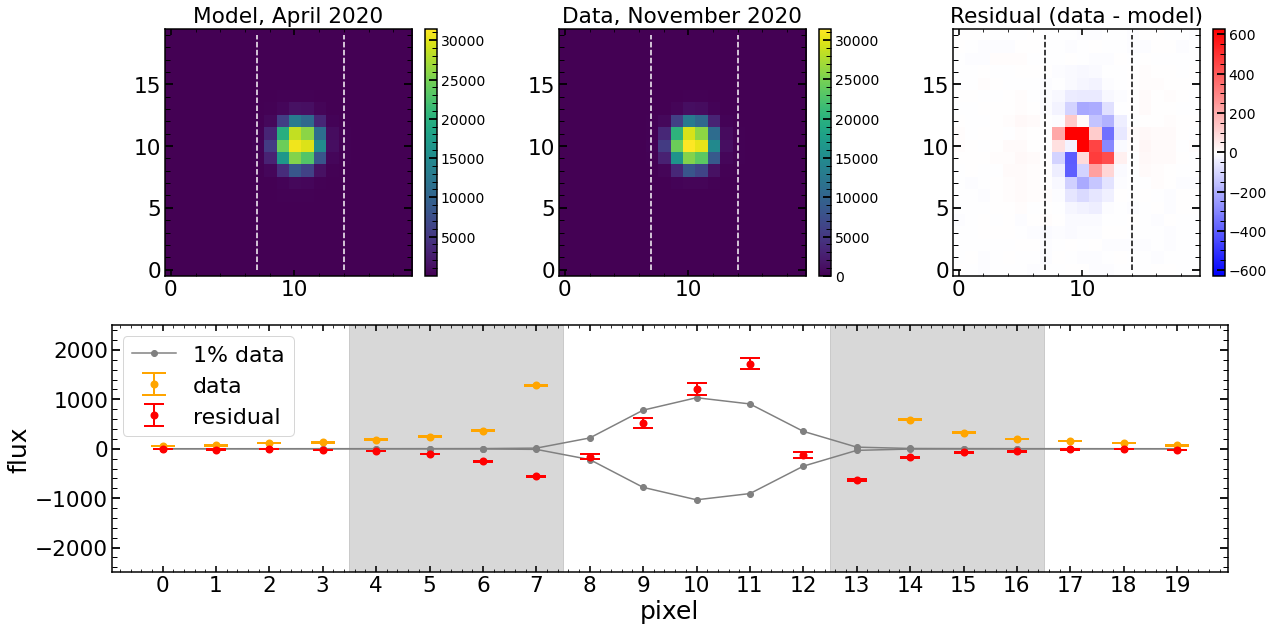

In [138]:


from matplotlib import gridspec
fig=plt.figure(figsize=(20,10))



ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0), colspan=3)


im1=ax1.imshow(res_iapetus,origin='lower',vmax=np.max(np.abs(sci_image)))
ax1.plot(np.ones(len(sci_image))*(left_limit+1),np.array(range(len(sci_image))),'--',color='white')
ax1.plot(np.ones(len(sci_image))*(right_limit+1),np.array(range(len(sci_image))),'--',color='white')
cb=fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04) 
cb.ax.tick_params(labelsize=14)
ax1.set_title('Model, April 2020')
#ax1.grid(False)



im2=ax2.imshow(sci_image,origin='lower',vmax=np.max(np.abs(sci_image)))
ax2.plot(np.ones(len(sci_image))*(left_limit+1),np.array(range(len(sci_image))),'--',color='white')
ax2.plot(np.ones(len(sci_image))*(right_limit+1),np.array(range(len(sci_image))),'--',color='white')
cb=fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04) 
cb.ax.tick_params(labelsize=14)
ax2.set_title('Data, November 2020')
ax2.grid(False)


im3=ax3.imshow(sci_image-res_iapetus,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image))/50,vmax=np.max(np.abs(sci_image))/50)
ax3.plot(np.ones(len(sci_image))*(left_limit+1),np.array(range(len(sci_image))),'--',color='black')
ax3.plot(np.ones(len(sci_image))*(right_limit+1),np.array(range(len(sci_image))),'--',color='black')
ax3.set_title('Residual (data - model)')
cb=fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04) 
cb.ax.tick_params(labelsize=14)

ax4.errorbar(np.array(range(len(init_lamda))),init_lamda,yerr=std_init_lamda,fmt='o',elinewidth=2,capsize=12,markeredgewidth=2,label='data',color='orange')
ax4.plot(np.array(range(len(init_lamda))),init_lamda*0.01,color='gray',label='1% data',marker='o')
ax4.plot(np.array(range(len(init_lamda))),-init_lamda*0.01,color='gray',marker='o')    
plt.errorbar(np.array(range(len(init_removal_lamda))),init_removal_lamda,yerr=std_init_removal_lamda,color='red',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='residual')

ax4.set_ylim(-2500,2500)
ax4.set_ylabel('flux',size=25)
ax4.set_xlabel('pixel',size=25)
ax4.set_xticks(range(20))
position_of_max_flux=np.where(init_lamda==np.max(init_lamda))[0][0]
difference_from_max=range(20)-position_of_max_flux
pixels_to_test=np.array(range(20))[(np.abs(difference_from_max)>2)&(np.abs(difference_from_max)<=6)]
plt.axvspan(pixels_to_test[0]-0.5, pixels_to_test[3]+0.5, alpha=0.3, color='grey')
plt.axvspan(pixels_to_test[4]-0.5, pixels_to_test[7]+0.5, alpha=0.3, color='grey')
plt.legend(loc=2, fontsize=22)

# poor results in red part of the detector - initial

In [ ]:
################################
Likelihoods returned per individual images are: [-86573.0390625  -43154.76953125 -14508.265625    -6258.16503906
  -2567.50537109  -6046.69189453 -40179.984375   -62832.9609375
 -85816.03125   ]
Mean likelihood is -38659.712565104164
################################
Renormalized likelihoods returned per individual images are: [-1436.03061805  -907.25693449  -409.26378577 -2604.44751977
 -2567.50537109 -3167.99729147 -1339.69326885 -1586.52086481
 -1676.59361709]
Renormalization factors are: [60.28634625 47.56620522 35.44966872  2.40287623  1.          1.90867963
 29.99192823 39.60424494 51.18475364]
Mean renormalized likelihood is -1743.9232523790238
array_of_psf_positions_output: [[ -9.28515283  -9.76126956]
 [ -5.30354758  -2.30427199]
 [ -1.56061473 -12.83151944]
 [  1.2281891   -3.08969462]
 [ -3.53079547  -4.77720202]
 [  0.31123736   3.12647859]
 [  3.13017795  -3.56910715]
 [  7.28607041   4.12405647]
 [  2.37247796  -6.59694915]]
    
    
################################
Likelihoods returned per individual images are: [-101865.796875    -48690.83984375  -15585.49609375   -6253.45898438
   -2575.41796875   -5282.85986328  -38641.69921875  -60384.0703125
  -83345.046875  ]
Mean likelihood is -40291.63178168403
################################
Renormalized likelihoods returned per individual images are: [-1689.69929701 -1023.64356418  -439.65138903 -2602.48901079
 -2575.41796875 -2767.80858526 -1288.40329695 -1524.6868208
 -1628.31782794]
Renormalization factors are: [60.28634625 47.56620522 35.44966872  2.40287623  1.          1.90867963
 29.99192823 39.60424494 51.18475364]
Mean renormalized likelihood is -1726.6797511906932
array_of_psf_positions_output: [[-10.66927255  -9.70450184]
 [ -6.53838697  -2.20832579]
 [ -2.6444103  -12.7382704 ]
 [  0.99999226  -2.98600595]
 [ -3.53090569  -4.78929412]
 [  0.70474709   2.88182048]
 [  4.11774419  -3.82597835]
 [  8.45946962   3.85244548]
 [  3.74328533  -6.88898143]]

In [181]:
from schwimmbad import MultiPool
#import mpi4py
from functools import partial

In [183]:
def f(x,y):
    return x+y

In [225]:
from multiprocessing import Pool
pool=Pool(4)

def f(x,y):
    return x*y

In [228]:
# random values
array_x=np.array([1.23,234.43])
array_y=np.arange(0,3,1)

In [229]:
out1=map(partial(f,array_x),array_y)
out2=np.array(list(out1))

out2

array([[  0.  ,   0.  ],
       [  1.23, 234.43],
       [  2.46, 468.86]])

In [230]:
out1=pool.map(partial(f,array_x),array_y)
out2=np.array(list(out1))

KeyboardInterrupt: 

In [219]:
out1=map(partial(f,array_x),array_y)
out2=np.array(list(out1))

out2

array([[ 7.65,  7.65,  7.65,  7.65,  7.65,  7.65,  7.65,  7.65,  7.65,
         7.65],
       [ 8.65,  8.65,  8.65,  8.65,  8.65,  8.65,  8.65,  8.65,  8.65,
         8.65],
       [ 9.65,  9.65,  9.65,  9.65,  9.65,  9.65,  9.65,  9.65,  9.65,
         9.65],
       [10.65, 10.65, 10.65, 10.65, 10.65, 10.65, 10.65, 10.65, 10.65,
        10.65],
       [11.65, 11.65, 11.65, 11.65, 11.65, 11.65, 11.65, 11.65, 11.65,
        11.65],
       [12.65, 12.65, 12.65, 12.65, 12.65, 12.65, 12.65, 12.65, 12.65,
        12.65],
       [13.65, 13.65, 13.65, 13.65, 13.65, 13.65, 13.65, 13.65, 13.65,
        13.65],
       [14.65, 14.65, 14.65, 14.65, 14.65, 14.65, 14.65, 14.65, 14.65,
        14.65],
       [15.65, 15.65, 15.65, 15.65, 15.65, 15.65, 15.65, 15.65, 15.65,
        15.65],
       [16.65, 16.65, 16.65, 16.65, 16.65, 16.65, 16.65, 16.65, 16.65,
        16.65]])

# Testing 0.41 

In [7]:
date='Jan2920'
#obs=34313
#obs_int=int(obs)
single_number='11'
image_index=int(single_number)
eps=6
arc='Ar'
dataset=6

if arc=='Ar':
    obs=34341+96
    finalArc=finalAr
if arc=='Ne':
    obs=34217+96 
    finalArc=finalNe
if arc=='Kr':
    obs=34561+96
    finalArc=finalKr



list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

finalArc.loc[int(single_number)]


NameError: name 'finalAr' is not defined

STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 11
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0 0]


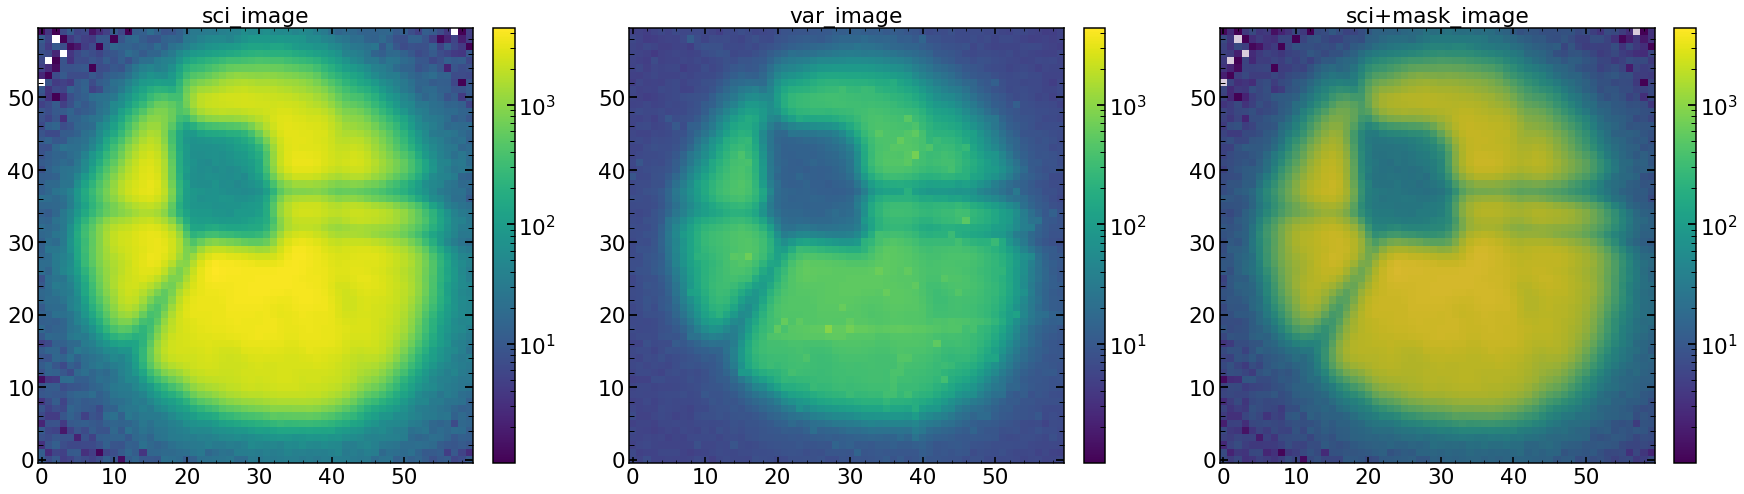

In [242]:
single_analysis=Zernike_Analysis(date=date,obs='m4',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                 list_of_defocuses=list_of_defocuses_input_long)
single_analysis.create_basic_data_image()

In [243]:
double_sources,double_sources_positions_ratios=single_analysis.return_double_sources()
list_of_sci_images,list_of_var_images,list_of_mask_images=single_analysis.return_lists_of_images()
index_of_single_image=single_analysis.return_index_of_single_image_in_list_of_images()
columns,columns22,columns22_analysis=single_analysis.return_columns()

chain0_swarm_1,likechain0_swarm_1=single_analysis.create_chains_swarm_1()
#chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain_parametrization,like_min=single_analysis.create_likelihood()

Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Jan2920/chainJan2920_Single_P_34437116ArSwarm1.npy
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Jan2920/chainJan2920_Single_P_34437116ArSwarm1.npy
(36, 480, 129)
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Jan2920/chainJan2920_Single_P_34437116ArSwarm1.npy
(36, 480, 129)
minimal likelihood is: 1726.404694340507
average chi2 reduced is: 6.912630005411592


In [244]:
model_multi=LN_PFS_multi_same_spot(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=1,zmax=56,verbosity=1,\
                      double_sources=double_sources,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=False)   

#list_of_minchain=model_multi.create_list_of_allparameters(t1,list_of_defocuses=list_of_defocuses_input_long,zmax=56)
list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=list_of_defocuses_input_long,zmax=56)
#list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=['m4','p4'],zmax=56)

#list_of_minchain_changed=np.copy(list_of_minchain)
#for i in range(9):
#    list_of_minchain_changed[i][35]=-0.8

res_multi=model_multi(list_of_minchain,return_Images=True)


mean_res_of_multi_same_spot,list_of_single_res,list_of_single_model_image,\
                list_of_single_allparameters,list_of_single_chi_results,array_of_psf_positions_output=res_multi

#model = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],dithering=1,save=1,zmax=22,verbosity=1,\
#                      double_sources=None,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)  

#res_with_Image=model(list_of_minchain[index_of_single_image],return_Image=True)

################################
analyzing image 1 out of 9
 
Science image shape is: (60, 60)
Top left pixel value of the science image is: 11.366353
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 6.2264752
Mask image shape is: (60, 60)
Sum of mask image is: 0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.41
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56

Entering lnlike_Neven
allparameters [   31.56312038    -2.88096594    -1.47991177    -0.28865244
     0.66206552    -0.48654684    -0.59783443     0.81060786
     0.05343278     0.19891624    -0.10302568    -0.02961167
     0.00181775     0.07589772     0.07340874    -0.04220434
    -0.082495      -0.01774715     0.14683251     0.70255835
     0.10599709    -0.21711041     0.27352715     0.0627802
     0.10376147     0.09

chi2 within shgo optimization routine (chi_2_almost_multi_values): [-10.59186547  -9.23590242] / 74.43178
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-10.0034285   -9.74900811] / 75.18915
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-9.41499153 -9.44114469] / 79.41119
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-10.0034285   -9.23590242] / 75.91934
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-10.0034285   -9.64638697] / 75.18089
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-10.59186547  -9.64638697] / 73.64686
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-10.88608395  -9.85162924] / 73.85212
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-11.18030244  -9.23590242] / 75.397156
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-10.29764698  -9.54376583] / 74.18396
chi2 within shgo optimization routine (chi_2_al

We are fitting for only one source
One source fitting result is [-10.66927255  -9.70450184]
type(complete_realization_renormalized)<class 'numpy.float32'>
Time for single_Psf_position protocol is 1.039468765258789
Sucesfully created optPsf_cut_fiber_convolved_downsampled
Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.9963348306337698
Finished with lnlike_Neven
chi_2_almost/d.o.f is 129.77779; chi_2_almost_max_dof is 15660.25 log(improvment) is -2.0815983
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4490204608
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4490204608 is: 12.119972944259644 seconds
 
##############

chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.76534189 -2.17218773] / 65.969955
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.50513643 -2.20879763] / 65.7405
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.50513643 -2.30642405] / 65.78191
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.5701878  -2.18744185] / 65.74258
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.48345265 -2.15083195] / 65.76273
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.56476685 -2.22176364] / 65.739716
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.49971549 -2.24311942] / 65.74742
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.55256972 -2.20136125] / 65.73709
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.61220014 -2.21432725] / 65.76024
chi2 within shgo optimization routine (chi_2_almost_multi_value

Time to apodize the pupil: 0.14586687088012695
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.3182368278503418
Time for pupil and illumination calculation is 0.3246736526489258

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, 23.680604680844993, -2.388548017975702, -1.2456888713881011, -0.3023022002718412, 0.5985389748658869, -0.4759012944381177, -0.5933313464055954, 0.7438932736161812, 0.044790320862015724, 0.19980665672430448, -0.0890053438301967, -0.019152196432930247, 0.010564935647408222, 0.0668292011739714, 0.06305157737780874, -0.03976485735341798, -0.07167567674824891, -0.01026971346915292, 0.11939570806324319, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, -2.388548017975702, -1.2456888713881011, -0.3023022002718412

chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -2.64440497 -12.73826511] / 62.23587
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -2.64441074 -12.73826824] / 62.23585
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -2.64440689 -12.73826615] / 62.23585
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -2.64440978 -12.73826772] / 62.23585
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -2.64440881 -12.7382672 ] / 62.23586
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -2.64441052 -12.73826932] / 62.235855
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -2.64441201 -12.73827252] / 62.23586
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -2.64440961 -12.73826853] / 62.235855
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -2.64441121 -12.73827119] / 62.23585
chi2 within shgo optimization routine (chi_2

Finished with _getOptPsf_naturalResolution
 
 
Entering optPsf_postprocessing
optPsf.shape: (3072, 3072)
oversampling_original: 35.374287997579025
size_of_central_cut: 990
optPsf_cut.shape(991, 991)
oversampling:9.0
optPsf_cut.shape[0]991
size_of_optPsf_cut_downsampled: 252.0
optPsf_cut_downsampled.shape: (253, 253)
size_of_optPsf_cut_in_Microns: 421.6666666666667
postprocessing parameters:
['grating_lines', 'scattering_slope', 'scattering_amplitude', 'pixel_effect', 'fiber_r']
[25718.097651645247, 2.3157202948525044, 0.007171277681464721, 0.4893968824173391, 1.8421537702381563]
type(pointsx): <class 'numpy.float32'>
optPsf_cut_downsampled_scattered.shape:(253, 253)
simulation_00 parameter:None
are we invoking double sources (1 or True if yes): False
double source position/ratio is:[0 0]
Time for postprocessing up to single_Psf_position protocol is 0.11432480812072754
offset_initial_and_sci: [ 0.05911438 -0.30135926]
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 

Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.988902199570035
Finished with lnlike_Neven
chi_2_almost/d.o.f is 87.637184; chi_2_almost_max_dof is 6205.055 log(improvment) is -1.8500572
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4490204608
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4490204608 is: 8.883414030075073 seconds
 
################################
analyzing image 5 out of 9
 
Science image shape is: (20, 20)
Top left pixel value of the science image is: -1.7947999
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 3.0357723
Mask image shape is: (20, 20)
Sum of mask ima

chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.25889272 -4.34022857] / 14.548615
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.2588927  -4.34022858] / 14.548618
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.2588927  -4.33549428] / 14.5591545
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.2588927  -4.33788856] / 14.553802
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.2588927  -4.33907191] / 14.551174
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.2588927  -4.33965683] / 14.54988
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.2588927  -4.33994595] / 14.549242
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.2588927  -4.34008887] / 14.548925
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.2588927  -4.34015952] / 14.54877
chi2 within shgo optimization routine (chi_2_almost_mult

Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.9935987503343457
Finished with lnlike_Neven
chi_2_almost/d.o.f is 40.211834; chi_2_almost_max_dof is 2835.6274 log(improvment) is -1.8482953
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4490204608
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4490204608 is: 9.105855941772461 seconds
 
################################
analyzing image 6 out of 9
 
Science image shape is: (20, 20)
Top left pixel value of the science image is: 1.330365
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 3.4698658
Mask image shape is: (20, 20)
Sum of mask ima

chi2 within shgo optimization routine (chi_2_almost_multi_values): [-0.15960794  3.75373008] / 31.199614
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.04478088 3.41309155] / 28.62127
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.13774974 3.25814777] / 27.801722
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.18123176 3.18567976] / 27.504288
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.20186907 3.15128521] / 27.3823
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.21173215 3.1348472 ] / 27.328354
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.21646159 3.12696502] / 27.30349
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.21873302 3.12317941] / 27.291782
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.21873303 3.12317941] / 27.291782
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.21873

Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.9851461959459248
Finished with lnlike_Neven
chi_2_almost/d.o.f is 85.40188; chi_2_almost_max_dof is 4191.829 log(improvment) is -1.6909362
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4490204608
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4490204608 is: 7.6507182121276855 seconds
 
################################
analyzing image 7 out of 9
 
Science image shape is: (50, 50)
Top left pixel value of the science image is: 5.400126
Variance image shape is: (50, 50)
Top left pixel value of the variance image is: 4.6791987
Mask image shape is: (50, 50)
Sum of mask imag

chi2 within shgo optimization routine (chi_2_almost_multi_values): [1.01730479 5.01429015] / 379.81146
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 3.82980479 -2.86070985] / 36.18595
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 3.82980481 -2.86070985] / 36.185944
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 3.82980479 -2.86070986] / 36.185947
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 12.82980477 -20.86070984] / 1912.2986
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  7.56867774 -10.33845576] / 260.59036
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 5.59573554 -6.39257134] / 67.26576
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 4.6978509  -4.59680206] / 35.73941
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 4.26404599 -3.72919225] / 32.236332
chi2 within shgo optimization routine (chi_2_almost_mult

We are fitting for only one source
One source fitting result is [ 4.11774419 -3.82597835]
type(complete_realization_renormalized)<class 'numpy.float32'>
Time for single_Psf_position protocol is 0.6146252155303955
Sucesfully created optPsf_cut_fiber_convolved_downsampled
Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.9994290150896142
Finished with lnlike_Neven
chi_2_almost/d.o.f is 63.487057; chi_2_almost_max_dof is 11929.502 log(improvment) is -2.2739372
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4490204608
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4490204608 is: 9.683540344238281 seconds
 
###############

chi2 within shgo optimization routine (chi_2_almost_multi_values): [8.69075274 3.67242783] / 35.428047
chi2 within shgo optimization routine (chi_2_almost_multi_values): [8.91945676 3.74443622] / 35.889957
chi2 within shgo optimization routine (chi_2_almost_multi_values): [8.2333447  3.81644461] / 35.330143
chi2 within shgo optimization routine (chi_2_almost_multi_values): [8.00464068 3.96046138] / 35.87797
chi2 within shgo optimization routine (chi_2_almost_multi_values): [8.69075274 3.81644461] / 35.329937
chi2 within shgo optimization routine (chi_2_almost_multi_values): [8.91945676 3.888453  ] / 35.876785
chi2 within shgo optimization routine (chi_2_almost_multi_values): [8.2333447  3.96046138] / 35.354816
chi2 within shgo optimization routine (chi_2_almost_multi_values): [8.34769671 3.888453  ] / 35.193306
chi2 within shgo optimization routine (chi_2_almost_multi_values): [8.80510475 3.888453  ] / 35.56173
chi2 within shgo optimization routine (chi_2_almost_multi_values): [8.37628

Time to apodize the pupil: 0.14453387260437012
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.31746602058410645
Time for pupil and illumination calculation is 0.3228590488433838

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -31.497005217904274, 1.058377409406387, 0.3938714213454353, -0.39785053203295295, 0.15385319198203085, -0.4013824743245392, -0.5618097462457253, 0.27689116632300725, -0.01570688471914472, 0.20603958954962512, 0.0091369984224281, 0.05406414782615562, 0.07179520919398118, 0.0033495863851810484, -0.009448544415223324, -0.022688484366883477, 0.004059564761825535, 0.04207233355752953, -0.07266188235666081, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, 1.058377409406387, 0.3938714213454353, -0.3978505320329

chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 4.33295829 -7.27166117] / 53.651093
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 4.33295829 -7.27166115] / 53.651093
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 4.5496062  -7.27166115] / 54.83324
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 4.33295829 -7.63524421] / 55.371136
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 4.5496062 -6.9080781] / 54.237484
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 4.33295829 -6.9080781 ] / 53.04059
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 4.22463433 -6.72628657] / 52.70512
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 4.00798641 -7.08986962] / 52.09269
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 3.73717652 -7.18076539] / 52.03886
chi2 within shgo optimization routine (chi_2_almost_multi_valu

We are fitting for only one source
One source fitting result is [ 3.74328533 -6.88898143]
type(complete_realization_renormalized)<class 'numpy.float32'>
Time for single_Psf_position protocol is 0.9348690509796143
Sucesfully created optPsf_cut_fiber_convolved_downsampled
Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.9977813985598092
Finished with lnlike_Neven
chi_2_almost/d.o.f is 97.456985; chi_2_almost_max_dof is 14060.782 log(improvment) is -2.1591966
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4490204608
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4490204608 is: 13.267203092575073 seconds
 
##############

In [246]:
array_of_var_sum=np.array(list(map(np.sum,list_of_var_images)))
index_of_max_var_sum=np.where(array_of_var_sum==np.min(array_of_var_sum))[0][0]
# find what variance selectes top 20% of pixels
# this is done to weight more the images in focus and less the image out of focus in the 
# final likelihood result
quantile_08_focus=np.quantile(list_of_sci_images[index_of_max_var_sum],0.8)




list_of_var_sums=[]
for i in range(9):
    var_image_masked=list_of_var_images[i]
    sci_image=list_of_sci_images[i]
    

    mean_value_of_background=np.mean([np.median(sci_image),np.median(sci_image),\
                      np.median(sci_image),np.median(sci_image)])*3
            
    #flux_mask=sci_image>(mean_value_of_background)
    #var_image_masked=var_image[flux_mask]
    
    var_image_masked_without_nan = var_image_masked.ravel()[var_image_masked.ravel()>quantile_08_focus]
    print(var_image_masked_without_nan.shape)
    var_sum=-(1/2)*(np.sum(np.log(2*np.pi*var_image_masked_without_nan)))
    list_of_var_sums.append(var_sum)
    
array_of_var_sum=np.array(list_of_var_sums)
max_of_array_of_var_sum=np.max(array_of_var_sum)
print(array_of_var_sum)
renormalization_of_var_sum=array_of_var_sum/max_of_array_of_var_sum

renormalization_of_var_sum

array_of_var_sum=np.array(list(map(np.sum,list_of_var_images)))
index_of_max_var_sum=np.where(array_of_var_sum==np.min(array_of_var_sum))[0][0]
# find what variance selectes top 20% of pixels
# this is done to weight more the images in focus and less the image out of focus in the 
# final likelihood result

quantile_08_focus=np.quantile(list_of_sci_images[index_of_max_var_sum],0.8)
quantile_08_focus

(2167,)
(1717,)
(1279,)
(92,)
(39,)
(74,)
(1072,)
(1405,)
(1805,)
[-7342.97558594 -5793.64160156 -4317.82763672  -292.67425537
  -121.80163574  -232.4803009  -3653.06591797 -4823.86181641
 -6234.38671875]


16.822856903076207

-1718.3758898492897
array_of_single_res: [-101093.0234375   -48532.5         -15557.74804688   -6305.91699219
   -2576.58276367   -5170.67382812  -38501.94921875  -60096.5703125
  -82827.8125    ]
renormalization factors: [60.28634625 47.56620522 35.44966872  2.40287623  1.          1.90867963
 29.99192823 39.60424494 51.18475364]


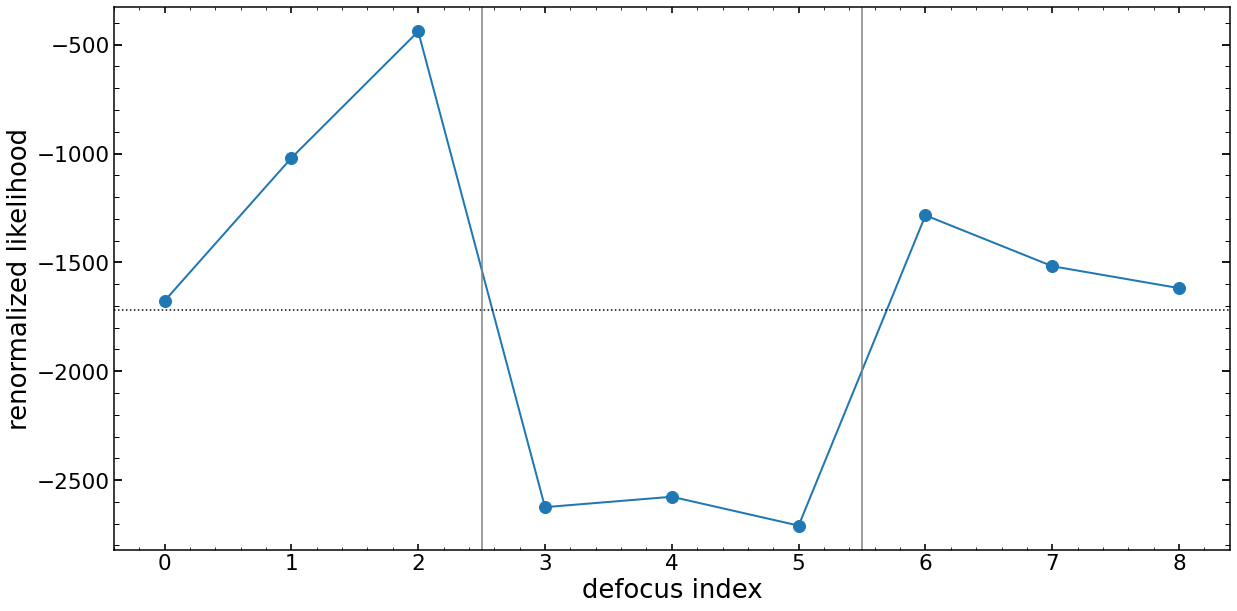

In [247]:
# shows the reported likelihood for each image, after division by the renormalization factor
# smaller absolute values is better
# dotted lien shows the mean reported value

plt.figure(figsize=(20,10))
array_of_single_res=np.array(list_of_single_res)

mean_res_of_multi_same_spot=np.mean(array_of_single_res/renormalization_of_var_sum)
print(mean_res_of_multi_same_spot)
print('array_of_single_res: '+str(array_of_single_res))
print('renormalization factors: '+str(renormalization_of_var_sum))
plt.plot(array_of_single_res/renormalization_of_var_sum,marker='o',lw=2,ms=12)
plt.xlabel('defocus index')
plt.ylabel('renormalized likelihood')
plt.axhline(mean_res_of_multi_same_spot,color='black',ls=":")
plt.axvline(2.5,color='gray')

plt.axvline(5.5,color='gray')

## Testing 0.41 via script 

In [251]:
finalAr_Feb2020_dataset=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalAr_Feb2020",allow_pickle=True)
finalNe_Feb2020_dataset=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalNe_Feb2020",allow_pickle=True)
finalKr_Feb2020_dataset=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalKr_Feb2020",allow_pickle=True)

finalAr=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalAr_Feb2020",allow_pickle=True)
finalNe=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalNe_Feb2020",allow_pickle=True)
finalKr=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalKr_Feb2020",allow_pickle=True)

def remove(string): 
    return string.replace(" ", "")

In [252]:
date='Mar06'

list_of_Ar_to_analyze=[2,11,17]

for single_spot in list_of_Ar_to_analyze:
    if str(finalAr_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalAr_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
        double_source=True
    else:
        double_source=False    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T_Ar_1_'+str(single_spot)+date+'.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 19:55:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, m35, m3, p3, p35, p4
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py -obs 34341 34347 34353 34383 34389 34395 34425 34431 34437 -spot "+str(single_spot)+\
               " -nsteps 36 -eps 6 -dataset 6 -arc Ar -double_sources "+str(double_source)+\
               " -double_sources_positions_ratios "+remove(str(list(finalAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+\
               " -twentytwo_or_extra 56 -date_of_input Jan0821 -direct_or_interpolation direct -date_of_output "+date+" -analysis_type defocus \n")
    file.close()    
  



file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/'+date+'ScriptToSubmitScriptsTiger_Ar_1_'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Ar_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T_Ar_1_'+str(single_spot)+date+'.sh \n')

file.close()

# Mar 06 2021

In [16]:
import glob

finalAr=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalAr_Feb2020",allow_pickle=True)
finalNe=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalNe_Feb2020",allow_pickle=True)
finalKr=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalKr_Feb2020",allow_pickle=True)

def remove(string): 
    return string.replace(" ", "")

## which are avaliable 

In [20]:

date='Mar0621'

ResultsFromTiger_FOLDER='/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/'


Emcee3_HgAr=glob.glob(ResultsFromTiger_FOLDER+date+'/chain'+date+'_Single_P_*HgArSwarm1.npy', recursive=True)

Emcee3_Ar=glob.glob(ResultsFromTiger_FOLDER+date+'/chain'+date+'_Single_P_*ArSwarm1.npy', recursive=True)
Emcee3_Ne=glob.glob(ResultsFromTiger_FOLDER+date+'/chain'+date+'_Single_P_*NeSwarm1.npy', recursive=True)
Emcee3_Kr=glob.glob(ResultsFromTiger_FOLDER+date+'/chain'+date+'_Single_P_*KrSwarm1.npy', recursive=True)


In [21]:
analyzed_Neon_images=[]
for i in range(len(Emcee3_Ne)):
    single_string=Emcee3_Ne[i][len(ResultsFromTiger_FOLDER)+30:len(Emcee3_Ne[i])-13]
    analyzed_Neon_images.append([int(single_string[:5]),int(single_string[5:]),'Ne'])
   
analyzed_Neon_images=np.array(analyzed_Neon_images)
###########
analyzed_Ar_images=[]
for i in range(len(Emcee3_Ar)):
    single_string=Emcee3_Ar[i][len(ResultsFromTiger_FOLDER)+30:len(Emcee3_Ar[i])-13]
    analyzed_Ar_images.append([int(single_string[:5]),int(single_string[5:]),'Ar'])
 

analyzed_Ar_images=np.array(analyzed_Ar_images)
###########
analyzed_Kr_images=[]
for i in range(len(Emcee3_Kr)):
    single_string=Emcee3_Kr[i][len(ResultsFromTiger_FOLDER)+30:len(Emcee3_Kr[i])-13]
    analyzed_Kr_images.append([int(single_string[:5]),int(single_string[5:]),'Kr'])
    
analyzed_Kr_images=np.array(analyzed_Kr_images)

In [22]:
print(analyzed_Ar_images)
print(analyzed_Neon_images)
print(analyzed_Kr_images)

[['34437' '23' 'Ar']
 ['34437' '2' 'Ar']]
[]
[]


In [23]:
if len(analyzed_Ar_images)>0:
    arranged_by_defocus_Ar=analyzed_Ar_images[analyzed_Ar_images[:,0].argsort()]
    arranged_by_spot_number_Ar=analyzed_Ar_images[analyzed_Ar_images[:,1].argsort()]
else:
    arranged_by_defocus_Ar=[]
    arranged_by_spot_number_Ar=[]

if len(analyzed_Neon_images)>0:
    arranged_by_defocus_Ne=analyzed_Neon_images[analyzed_Neon_images[:,0].argsort()]
    arranged_by_spot_number_Ne=analyzed_Neon_images[analyzed_Neon_images[:,1].argsort()]
else:
    arranged_by_defocus_Ne=[]
    arranged_by_spot_number_Ne=[]

if len(analyzed_Kr_images)>0:
    arranged_by_defocus_Kr=analyzed_Kr_images[analyzed_Kr_images[:,0].argsort()]
    arranged_by_spot_number_Kr=analyzed_Kr_images[analyzed_Kr_images[:,1].argsort()]
else:
    arranged_by_defocus_Kr=[]
    arranged_by_spot_number_Kr=[]
    
print('analyzed_Ar_images:'+str(len(analyzed_Ar_images))+' / '+'analyzed_Ne_images:'+str(len(analyzed_Neon_images))+' / '+'analyzed_Kr_images:'+str(len(analyzed_Kr_images)))

analyzed_Ar_images:2 / analyzed_Ne_images:0 / analyzed_Kr_images:0


## single image analysis 

In [24]:
date='Mar0621'
#obs=34313
#obs_int=int(obs)
single_number='23'
image_index=int(single_number)
eps=6
arc='Ar'
dataset=6

if arc=='Ar':
    obs=34341+96
    finalArc=finalAr
if arc=='Ne':
    obs=34217+96 
    finalArc=finalNe
if arc=='Kr':
    obs=34561+96
    finalArc=finalKr



list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

finalArc.loc[int(single_number)]

fiber                   63
xc                     453
yc                    4020
wavelength        966.0642
close                    1
lamp                    Ar
xc_effective           453
second_offset            0
second_ratio             0
second2_offset           0
second2_ratio            0
Name: 23, dtype: object

STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 23
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0 0]


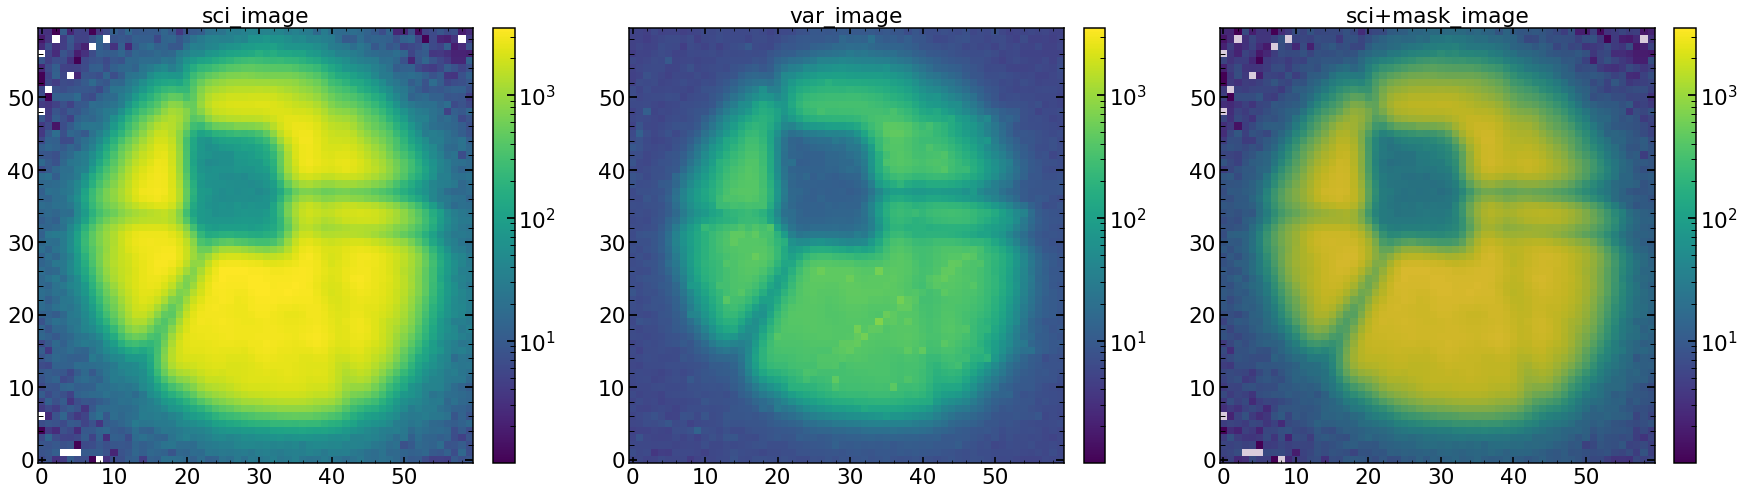

In [25]:
single_analysis=Zernike_Analysis(date=date,obs='m4',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                 list_of_defocuses=list_of_defocuses_input_long)
single_analysis.create_basic_data_image()

In [26]:
double_sources,double_sources_positions_ratios=single_analysis.return_double_sources()
list_of_sci_images,list_of_var_images,list_of_mask_images=single_analysis.return_lists_of_images()
index_of_single_image=single_analysis.return_index_of_single_image_in_list_of_images()
columns,columns22,columns22_analysis=single_analysis.return_columns()


chain0_swarm_1,likechain0_swarm_1=single_analysis.create_chains_swarm_1()
#chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain_parametrization,like_min=single_analysis.create_likelihood()

Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Mar0621/chainMar0621_Single_P_34437236ArSwarm1.npy
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Mar0621/chainMar0621_Single_P_34437236ArSwarm1.npy
(36, 480, 129)
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Mar0621/chainMar0621_Single_P_34437236ArSwarm1.npy
(36, 480, 129)
minimal likelihood is: 1381.0325934973669
average chi2 reduced is: 4.623558198733842


### chain analysis 

In [27]:
minchain_parametrization

array([   -7.85211878,     0.06417253,     0.40713329,    -0.8728712 ,
           0.24052133,    -0.58921053,    -0.02887021,    -0.28431933,
          -0.02707785,     0.31416349,     0.00444547,    -0.28576882,
           0.00857085,    -0.57368226,    -0.01176668,     0.30737536,
           0.00415327,     0.00555316,     0.00931343,     0.15454718,
           0.01481438,    -0.03136635,    -0.00192201,     0.04889005,
          -0.00002182,    -0.00323497,    -0.01960116,     0.03051556,
          -0.01224953,     0.01522298,     0.0030405 ,    -0.02297179,
           0.00838428,    -0.04266018,     0.01065904,     0.02251537,
          -0.01852399,     0.01572249,     0.67572462,     0.10980972,
          -0.16472781,     0.25111013,     0.06468161,     0.08201545,
           0.10894318,     0.19164474,     0.        ,     2.01287523,
          -0.05162714,    -0.03813197,     0.89603746,     0.04215063,
           0.77561409,     1.06865564,     0.4713123 , 26856.92186229,
      

In [28]:
gbest_filename='/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_'+str(obs)+str(single_number)+str(dataset)+arc+'res_gbests_position.npy'
gbests_positions=np.load(gbest_filename)
print(gbest_filename)
print(gbests_positions.shape)
gbests_positions[0]

/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Mar0621/chainMar0621_Single_P_34437236Arres_gbests_position.npy
(36, 129)


array([   -7.84771487,     0.07958407,     0.40562345,    -0.84101922,
           0.25192011,    -0.57141173,    -0.02254687,    -0.28359438,
          -0.03587075,     0.31332143,    -0.0003842 ,    -0.27331947,
          -0.00465112,    -0.5573254 ,    -0.01756292,     0.30361134,
           0.00139711,     0.00881324,     0.00563128,     0.15700183,
           0.01614701,    -0.02745355,    -0.0031288 ,     0.05988108,
           0.00464481,    -0.00315655,    -0.02221328,     0.03328858,
          -0.00591562,     0.01512311,     0.00270268,    -0.02010092,
           0.00795203,    -0.04123913,     0.00664515,     0.03108906,
          -0.01867095,     0.01623162,     0.68221413,     0.11226517,
          -0.16362662,     0.25236131,     0.06285819,     0.07671953,
           0.1186272 ,     0.09696087,     0.        ,     1.90727728,
          -0.04705618,    -0.04017216,     0.89588263,     0.04728633,
           0.63735055,     1.06552843,     0.48736339, 27501.92348639,
      

Text(0, 0.5, 'par_1')

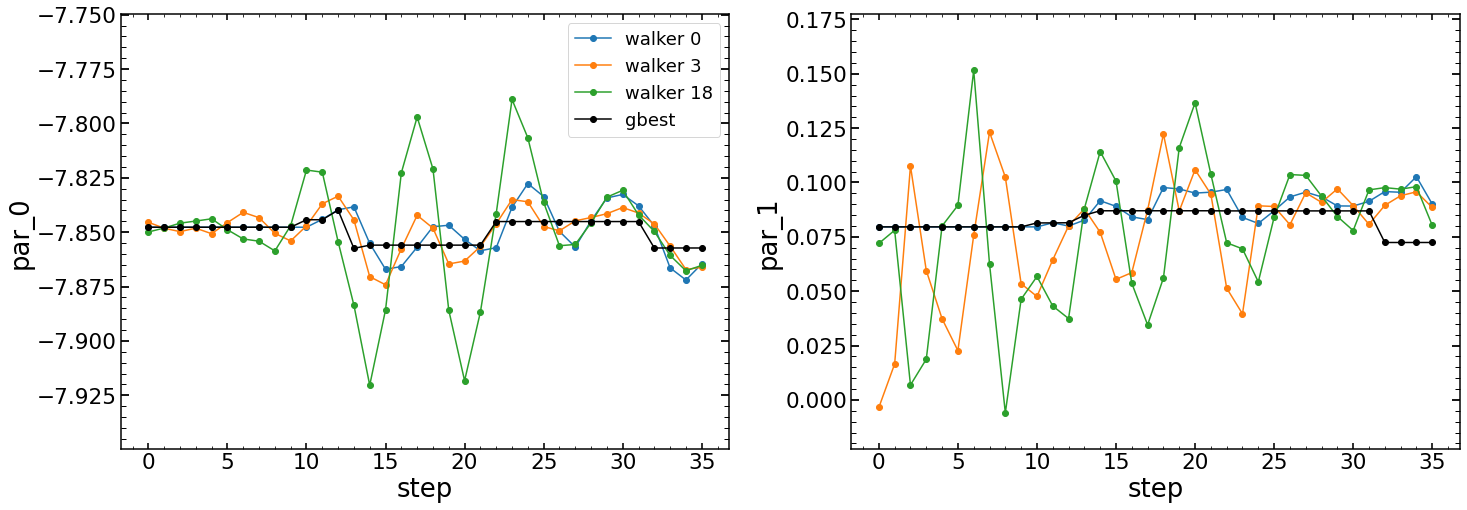

In [29]:
# wavefront paramter
plt.figure(figsize=(24,8))
i=0*2
plt.subplot(121)
# two different walkers, parameter 0
plt.plot(chain0_swarm_1[:,0][:,i],label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i],label='gbest',color='black',marker='o')
plt.xlabel('step')
plt.ylabel('par_'+str((i)))
mean_one_walker=np.mean(chain0_swarm_1[:,18][:,i])
plt.ylim(mean_one_walker-0.1,mean_one_walker+0.1)
plt.legend()

plt.subplot(122)
#  paramter 2 (z5)

mean_one_what=np.mean(chain0_swarm_1[:,:,i+1][:,2])
plt.plot(chain0_swarm_1[:,:,i+1][:,0],marker='o')
plt.plot(chain0_swarm_1[:,:,i+1][:,3],marker='o')
plt.plot(chain0_swarm_1[:,:,i+1][:,18],marker='o')
plt.plot(gbests_positions[:,i+1],label='gbest',color='black',marker='o')
plt.ylim(mean_one_what-0.1,mean_one_what+0.1)
plt.xlabel('step')
plt.ylabel('par_'+str((i+1)))

Text(0.5, 1.0, 'par_46 / wide_43')

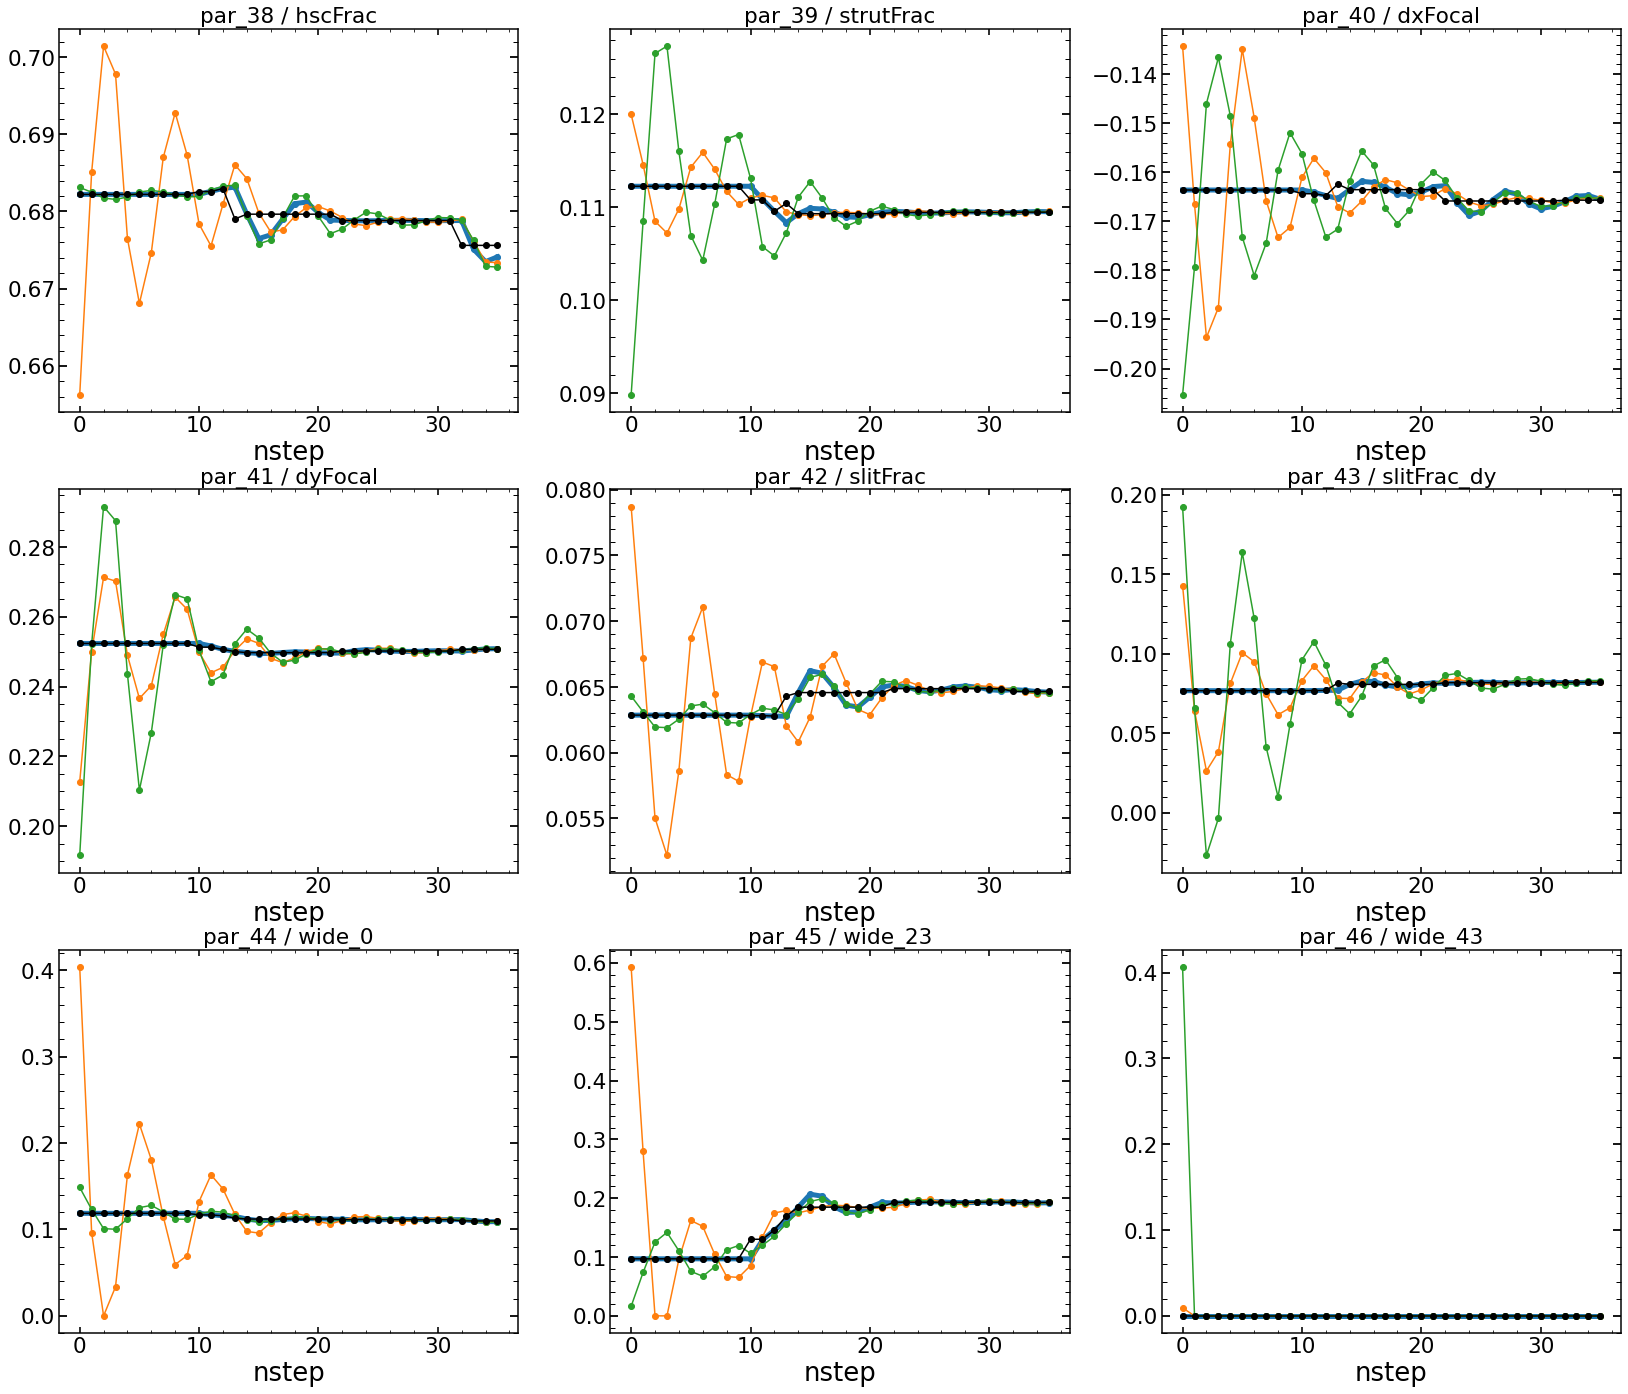

In [30]:
# pupil paramters
plt.figure(figsize=(28,24))
i=19*2
plt.subplot(331)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i))+' / '+columns22[19])

plt.subplot(332)
plt.plot(chain0_swarm_1[:,:,i+1][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+1][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+1][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+1],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+1))+' / '+columns22[20])

plt.subplot(333)
plt.plot(chain0_swarm_1[:,:,i+2][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+2][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+2][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+2],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+2))+' / '+columns22[21])



plt.subplot(334)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+3],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+3],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+3],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+3))+' / '+columns22[19+3])

plt.subplot(335)
plt.plot(chain0_swarm_1[:,:,i+4][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+4][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+4][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+4],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+4))+' / '+columns22[19+4])

plt.subplot(336)
plt.plot(chain0_swarm_1[:,:,i+5][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+5][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+5][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+5],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+5))+' / '+columns22[19+5])


plt.subplot(337)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+6],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+6],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+6],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+6],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+6))+' / '+columns22[19+6])

plt.subplot(338)
plt.plot(chain0_swarm_1[:,:,i+7][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+7][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+7][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+7],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+7))+' / '+columns22[19+7])

plt.subplot(339)
plt.plot(chain0_swarm_1[:,:,i+8][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+8][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+8][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+8],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+8))+' / '+columns22[19+8])

Text(0.5, 1.0, 'par_58 / pixel_effect')

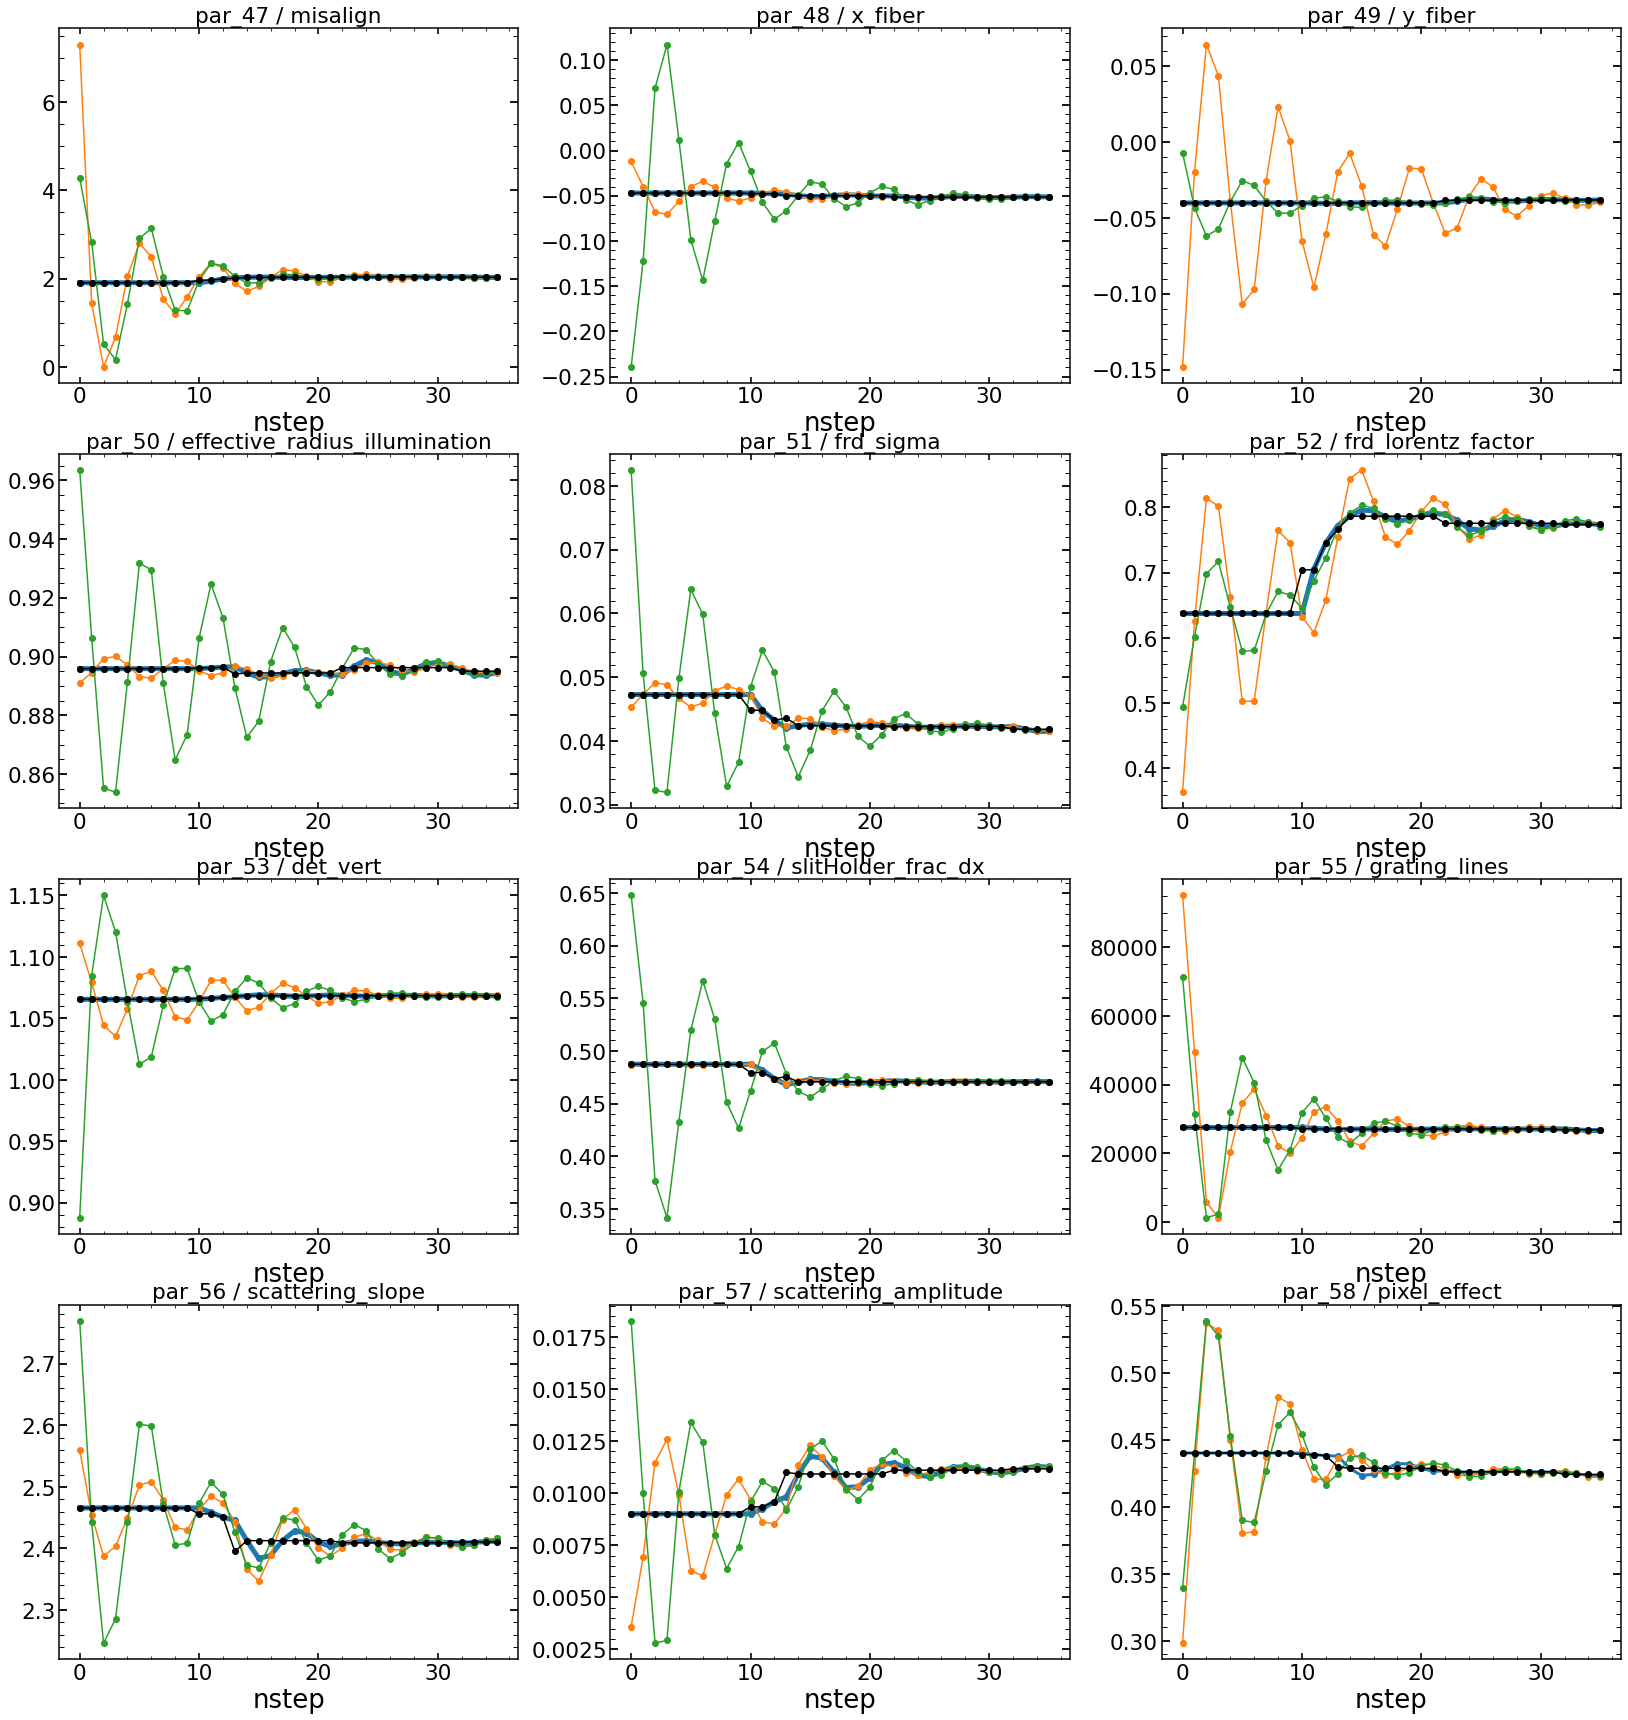

In [31]:
# pupil paramters
plt.figure(figsize=(28,30))
i=19*2
plt.subplot(431)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+9],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+9],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+9],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+9],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+9))+' / '+columns22[19+9])

plt.subplot(432)
plt.plot(chain0_swarm_1[:,:,i+10][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+10][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+10][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+10],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+10))+' / '+columns22[19+10])

plt.subplot(433)
plt.plot(chain0_swarm_1[:,:,i+11][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+11][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+11][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+11],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+11))+' / '+columns22[19+11])



plt.subplot(434)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+12],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+12],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+12],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+12],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+12))+' / '+columns22[19+12])

plt.subplot(435)
plt.plot(chain0_swarm_1[:,:,i+13][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+13][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+13][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+13],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+13))+' / '+columns22[19+13])

plt.subplot(436)
plt.plot(chain0_swarm_1[:,:,i+14][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+14][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+14][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+14],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+14))+' / '+columns22[19+14])


plt.subplot(437)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+15],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+15],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+15],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+15],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+15))+' / '+columns22[19+15])

plt.subplot(438)
plt.plot(chain0_swarm_1[:,:,i+16][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+16][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+16][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+16],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+16))+' / '+columns22[19+16])

plt.subplot(439)
plt.plot(chain0_swarm_1[:,:,i+17][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+17][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+17][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+17],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+17))+' / '+columns22[19+17])


plt.subplot(4,3,10)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+18],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+18],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+18],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+18))+' / '+columns22[19+18])

plt.subplot(4,3,11)
plt.plot(chain0_swarm_1[:,:,i+19][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+19][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+19][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+19],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+19))+' / '+columns22[19+19])

plt.subplot(4,3,12)
plt.plot(chain0_swarm_1[:,:,i+20][:,0],lw=3,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+20][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+20][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+20],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+20))+' / '+columns22[19+20])

Text(0, 0.5, 'std. devation of a single parameter 38')

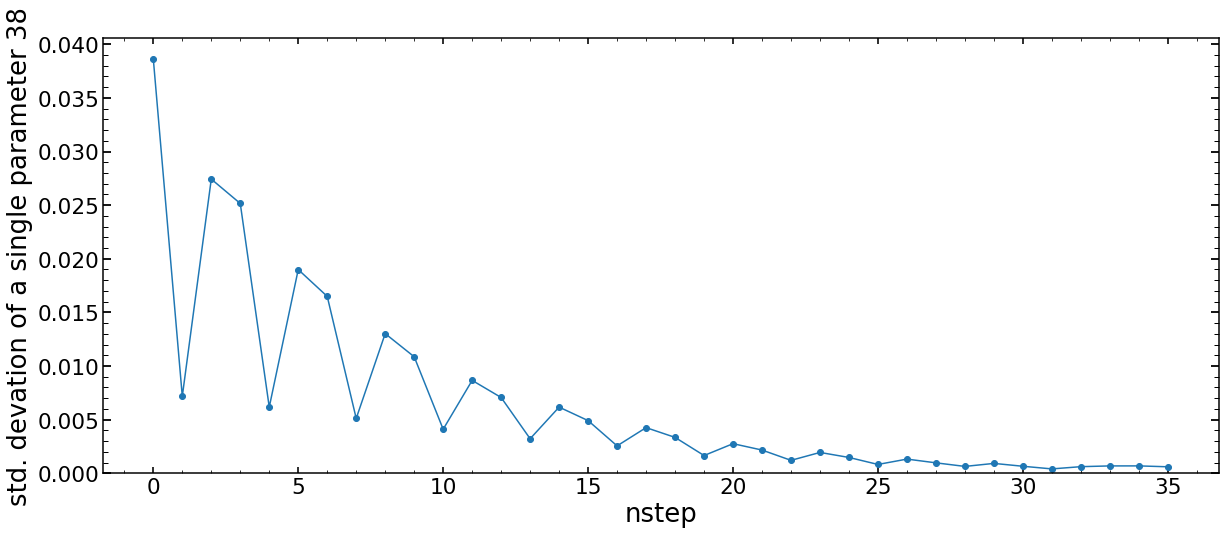

In [32]:
list_of_std=[]
i=19*2+0
for j in range(len(chain0_swarm_1)):
    list_of_std.append(np.std(chain0_swarm_1[:,:,i][j]))

plt.figure(figsize=(20,8))
plt.plot(list_of_std,marker='o')
plt.ylim(0)
plt.xlabel('nstep')
plt.ylabel('std. devation of a single parameter '+str(i))

Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Mar0621/chainMar0621_Single_P_34437236ArSwarm1.npy
(36, 480, 129)
minimal likelihood is: 1381.0325934973669
average chi2 reduced is: 4.623558198733842
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Mar0621/chainMar0621_Single_P_34437236ArSwarm1.npy
(36, 480, 129)


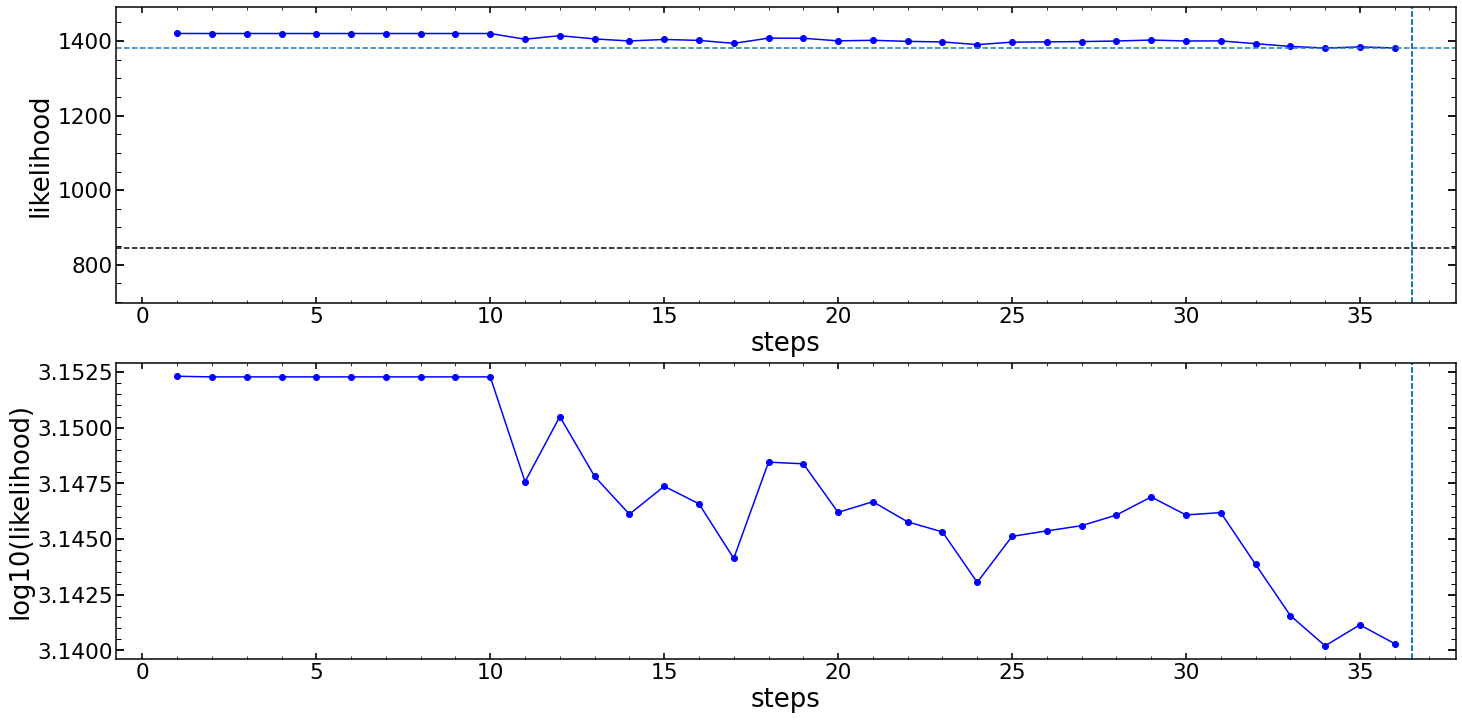

In [33]:
single_analysis.create_fitting_evolution_plot()

### image analysis 

In [34]:
model_multi=LN_PFS_multi_same_spot(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=1,zmax=56,verbosity=1,\
                      double_sources=double_sources,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=False)   


list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=list_of_defocuses_input_long,zmax=56)
list_of_minchain=model_multi.create_list_of_allparameters(gbests_positions[-1],list_of_defocuses=list_of_defocuses_input_long,zmax=56)



res_multi=model_multi(list_of_minchain,return_Images=True)


mean_res_of_multi_same_spot,list_of_single_res,list_of_single_model_image,\
                list_of_single_allparameters,list_of_single_chi_results,array_of_psf_positions_output=res_multi

#model = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],dithering=1,save=1,zmax=22,verbosity=1,\
#                      double_sources=None,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)  

#res_with_Image=model(list_of_minchain[index_of_single_image],return_Image=True)

################################
analyzing image 1 out of 9
 
Science image shape is: (60, 60)
Top left pixel value of the science image is: 5.84908
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 5.4849067
Mask image shape is: (60, 60)
Sum of mask image is: 0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.41b
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56

Entering lnlike_Neven
allparameters [   31.50147936    -2.47759418    -1.54542728    -0.16159195
     0.43335315    -0.29433927    -0.59640209     0.36509
    -0.00572004     0.12206806    -0.08339574     0.06344444
    -0.00088674     0.1137435      0.06238877    -0.03256918
    -0.07536294    -0.0144631      0.09419499     0.67561316
     0.10947574    -0.16569378     0.25066435     0.06465686
     0.08196768     0.10983

chi2 within shgo optimization routine (chi_2_almost_multi_values): [-15.24556048 -10.28349147] / 64.723175
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-25.37056009   9.96650836] / 1961.0544
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-19.88388052  -1.0068511 ] / 515.1789
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-17.45972485  -5.85516258] / 190.7873
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-16.32269777  -8.1292168 ] / 105.765045
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-15.77429215  -9.22602808] / 80.061386
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-15.50623393  -9.76214453] / 71.12568
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-15.37435261 -10.02590717] / 67.58815
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-15.3092646 -10.1560832] / 66.07335
chi2 within shgo optimization routine (chi_

We are fitting for only one source
One source fitting result is [-14.35715597 -11.340169  ]
type(complete_realization_renormalized)<class 'numpy.float32'>
Time for single_Psf_position protocol is 0.6778547763824463
Sucesfully created optPsf_cut_fiber_convolved_downsampled
Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.996403520498922
Finished with lnlike_Neven
chi_2_almost/d.o.f is 104.066734; chi_2_almost_max_dof is 13414.607 log(improvment) is -2.110266
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4556363200
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4556363200 is: 6.288629055023193 seconds
 
##############

chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -7.4905328  -12.63805115] / 53.3382
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -7.48974068 -12.64994834] / 53.337845
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -7.48602344 -12.64910047] / 53.337864
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -7.49040336 -12.64708003] / 53.337837
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -7.49199794 -12.65146969] / 53.3379
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -7.48910906 -12.64703643] / 53.337826
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -7.48977174 -12.64416811] / 53.337875
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -7.48974844 -12.64850329] / 53.337826
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -7.48845414 -12.64845969] / 53.337826
chi2 within shgo optimization routine (ch

Time for postprocessing pupil after _get_Pupil 0.2460801601409912
Time for pupil and illumination calculation is 0.2509469985961914

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, 23.64421174007897, -2.070866387686689, -1.301069470106961, -0.19150132589293883, 0.4065501260361386, -0.28923404810853853, -0.5885392394916151, 0.35237132662709236, -0.0022679860339096906, 0.13099795603610104, -0.0685037151587987, 0.06192035571067082, -0.0006008192024432174, 0.09380466703558432, 0.0508920207468371, -0.02964561636069296, -0.0665439364149574, -0.0034657651831175827, 0.07555956990625687, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, -2.070866387686689, -1.301069470106961, -0.19150132589293883, 0.4065501260361386, -0.28923404810853853, -0.5885392394916151, 0, -0.0022679860339096906, 0.1309

We are fitting for only one source
One source fitting result is [ -9.95779405 -13.88705944]
type(complete_realization_renormalized)<class 'numpy.float32'>
Time for single_Psf_position protocol is 0.3627917766571045
Sucesfully created optPsf_cut_fiber_convolved_downsampled
Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 1.0095376975020858
Finished with lnlike_Neven
chi_2_almost/d.o.f is 57.103092; chi_2_almost_max_dof is 18704.26 log(improvment) is -2.515281
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4556363200
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4556363200 is: 4.414870023727417 seconds
 
###############

chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.25732361 -2.63331151] / 31.513245
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.25745256 -2.6334531 ] / 31.513252
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.25729184 -2.63332792] / 31.513247
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.25739899 -2.63341137] / 31.513254
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.25731863 -2.63334879] / 31.513247
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.25734541 -2.63336965] / 31.513252
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.25732953 -2.63337785] / 31.513252
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.2573831  -2.63341958] / 31.513252
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.25734292 -2.63338828] / 31.513252
chi2 within shgo optimization routine (chi_2_almost_mul

creating wf_full_fake_0
Time for wavefront and wavefront/pupil combining is 0.00040912628173828125
type(expwf_grid)<class 'numpy.complex64'>
Time for FFT is 0.3038651943206787
type(img_apod)<class 'numpy.float32'>
Finished with _getOptPsf_naturalResolution
 
 
Entering optPsf_postprocessing
optPsf.shape: (3072, 3072)
oversampling_original: 35.374287997579025
size_of_central_cut: 990
optPsf_cut.shape(991, 991)
oversampling:9.0
optPsf_cut.shape[0]991
size_of_optPsf_cut_downsampled: 252.0
optPsf_cut_downsampled.shape: (253, 253)
size_of_optPsf_cut_in_Microns: 421.6666666666667
postprocessing parameters:
['grating_lines', 'scattering_slope', 'scattering_amplitude', 'pixel_effect', 'fiber_r']
[26808.192313805488, 2.4105171552794897, 0.011169443926434035, 0.4243194483154635, 1.8501571492702267]
type(pointsx): <class 'numpy.float32'>
optPsf_cut_downsampled_scattered.shape:(253, 253)
simulation_00 parameter:None
are we invoking double sources (1 or True if yes): False
double source position/ra

chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.75598871 -4.2449928 ] / 9.348203
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.73600759 -4.23749046] / 9.342169
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.76200712 -4.20976031] / 9.347945
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.71777181 -4.23532998] / 9.340625
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.71079045 -4.21396257] / 9.341192
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.71709474 -4.21984454] / 9.3404045
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.70584031 -4.23905147] / 9.341581
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.72322975 -4.22185516] / 9.340321
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.72255268 -4.20636972] / 9.341479
chi2 within shgo optimization routine (chi_2_almost_multi_value

Time to apodize the pupil: 0.12360382080078125
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.26217079162597656
Time for pupil and illumination calculation is 0.2676682472229004

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -3.856224918549004, -0.6473191030398997, -0.4458171202269128, -0.2961841410672438, 0.3127395404550945, -0.2713657794780107, -0.5610192606787002, 0.30785598286716326, 0.009814212810512087, 0.16225259889952706, -0.01638162842342761, 0.05658606781927454, 0.00039988957362465175, 0.024018739951631167, 0.010653411519057517, -0.019413142413519404, -0.035677427144983995, 0.03502491123855519, 0.010335585345749427, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, -0.6473191030398997, -0.4458171202269128, -0.296184

chi2 within shgo optimization routine (chi_2_almost_multi_values): [2.12984289 3.84762948] / 19.908789
chi2 within shgo optimization routine (chi_2_almost_multi_values): [2.13065316 3.84804477] / 19.908796
chi2 within shgo optimization routine (chi_2_almost_multi_values): [2.13036752 3.84757342] / 19.908794
chi2 within shgo optimization routine (chi_2_almost_multi_values): [2.12979624 3.84663073] / 19.90879
chi2 within shgo optimization routine (chi_2_almost_multi_values): [2.12931827 3.84768553] / 19.908789
chi2 within shgo optimization routine (chi_2_almost_multi_values): [2.12936493 3.84868428] / 19.908806
chi2 within shgo optimization routine (chi_2_almost_multi_values): [2.12968841 3.84714412] / 19.908794
chi2 within shgo optimization routine (chi_2_almost_multi_values): [2.12958058 3.8476575 ] / 19.90879
chi2 within shgo optimization routine (chi_2_almost_multi_values): [2.12981956 3.8471301 ] / 19.90879
chi2 within shgo optimization routine (chi_2_almost_multi_values): [2.129603

creating wf_full_fake_0
Time for wavefront and wavefront/pupil combining is 0.0007641315460205078
type(expwf_grid)<class 'numpy.complex64'>
Time for FFT is 0.30353307723999023
type(img_apod)<class 'numpy.float32'>
Finished with _getOptPsf_naturalResolution
 
 
Entering optPsf_postprocessing
optPsf.shape: (3072, 3072)
oversampling_original: 35.374287997579025
size_of_central_cut: 2476
optPsf_cut.shape(2477, 2477)
oversampling:9.0
optPsf_cut.shape[0]2477
size_of_optPsf_cut_downsampled: 630.0
optPsf_cut_downsampled.shape: (631, 631)
size_of_optPsf_cut_in_Microns: 1051.6666666666667
postprocessing parameters:
['grating_lines', 'scattering_slope', 'scattering_amplitude', 'pixel_effect', 'fiber_r']
[26808.192313805488, 2.4105171552794897, 0.011169443926434035, 0.4243194483154635, 1.8501571492702267]
type(pointsx): <class 'numpy.float32'>
optPsf_cut_downsampled_scattered.shape:(631, 631)
simulation_00 parameter:None
are we invoking double sources (1 or True if yes): False
double source positi

chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.81377906 -1.89810271] / 23.837194
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.81416252 -1.89692343] / 23.837194
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.8140347  -1.89731652] / 23.837194
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.81384632 -1.89701988] / 23.837193
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.81321391 -1.89721278] / 23.837194
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.8138295  -1.89729059] / 23.837193
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.81427353 -1.89680104] / 23.837194
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.8136201  -1.89733233] / 23.83719
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.81363692 -1.89706162] / 23.837194
chi2 within shgo optimization routine (chi_2_almost_mult

creating wf_full_fake_0
Time for wavefront and wavefront/pupil combining is 0.0004363059997558594
type(expwf_grid)<class 'numpy.complex64'>
Time for FFT is 0.31250500679016113
type(img_apod)<class 'numpy.float32'>
Finished with _getOptPsf_naturalResolution
 
 
Entering optPsf_postprocessing
optPsf.shape: (3072, 3072)
oversampling_original: 35.374287997579025
size_of_central_cut: 2971
optPsf_cut.shape(2972, 2972)
oversampling:9.0
optPsf_cut.shape[0]2972
size_of_optPsf_cut_downsampled: 756.0
optPsf_cut_downsampled.shape: (757, 757)
size_of_optPsf_cut_in_Microns: 1261.6666666666667
postprocessing parameters:
['grating_lines', 'scattering_slope', 'scattering_amplitude', 'pixel_effect', 'fiber_r']
[26808.192313805488, 2.4105171552794897, 0.011169443926434035, 0.4243194483154635, 1.8501571492702267]
type(pointsx): <class 'numpy.float32'>
optPsf_cut_downsampled_scattered.shape:(757, 757)
simulation_00 parameter:None
are we invoking double sources (1 or True if yes): False
double source positi

chi2 within shgo optimization routine (chi_2_almost_multi_values): [7.77481874 5.97246568] / 26.323
chi2 within shgo optimization routine (chi_2_almost_multi_values): [7.77608103 5.97383502] / 26.323
chi2 within shgo optimization routine (chi_2_almost_multi_values): [7.77513431 5.97280801] / 26.322994
chi2 within shgo optimization routine (chi_2_almost_multi_values): [7.77605666 5.97247399] / 26.322996
chi2 within shgo optimization routine (chi_2_almost_multi_values): [7.77527991 5.97229867] / 26.323
chi2 within shgo optimization routine (chi_2_almost_multi_values): [7.77575327 5.97281217] / 26.323
chi2 within shgo optimization routine (chi_2_almost_multi_values): [7.77559549 5.972641  ] / 26.322994
chi2 within shgo optimization routine (chi_2_almost_multi_values): [7.77552269 5.97289568] / 26.322996
chi2 within shgo optimization routine (chi_2_almost_multi_values): [7.77520711 5.97255334] / 26.323
chi2 within shgo optimization routine (chi_2_almost_multi_values): [7.77544379 5.9728100

creating wf_full_fake_0
Time for wavefront and wavefront/pupil combining is 0.0004980564117431641
type(expwf_grid)<class 'numpy.complex64'>
Time for FFT is 0.30909204483032227
type(img_apod)<class 'numpy.float32'>
Finished with _getOptPsf_naturalResolution
 
 
Entering optPsf_postprocessing
optPsf.shape: (3072, 3072)
oversampling_original: 35.374287997579025
size_of_central_cut: 2971
optPsf_cut.shape(2972, 2972)
oversampling:9.0
optPsf_cut.shape[0]2972
size_of_optPsf_cut_downsampled: 756.0
optPsf_cut_downsampled.shape: (757, 757)
size_of_optPsf_cut_in_Microns: 1261.6666666666667
postprocessing parameters:
['grating_lines', 'scattering_slope', 'scattering_amplitude', 'pixel_effect', 'fiber_r']
[26808.192313805488, 2.4105171552794897, 0.011169443926434035, 0.4243194483154635, 1.8501571492702267]
type(pointsx): <class 'numpy.float32'>
optPsf_cut_downsampled_scattered.shape:(757, 757)
simulation_00 parameter:None
are we invoking double sources (1 or True if yes): False
double source positi

chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 5.65771955 -4.57735278] / 38.15973
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 5.65778581 -4.57746652] / 38.15972
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 5.65783445 -4.57758128] / 38.15973
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 5.65774828 -4.57740991] / 38.159737
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 5.657777   -4.57746703] / 38.159737
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 5.65774387 -4.57741016] / 38.15973
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 5.65773506 -4.57741067] / 38.15973
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 5.65774554 -4.57742476] / 38.159737
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 5.65775603 -4.57743885] / 38.15973
chi2 within shgo optimization routine (chi_2_almost_multi_val

In [47]:
list_of_var_images_via_model=[]
for index_of_single_image in range(len(list_of_sci_images)):
    single_var_image_via_model=create_custom_var(modelImg=list_of_single_model_image[index_of_single_image],sci_image=list_of_sci_images[index_of_single_image],
                                    var_image=list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image])
    
    list_of_var_images_via_model.append(single_var_image_via_model)

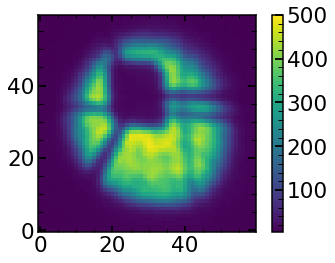

In [56]:
plt.imshow(list_of_var_images_via_model[0],vmax=500)
plt.colorbar()

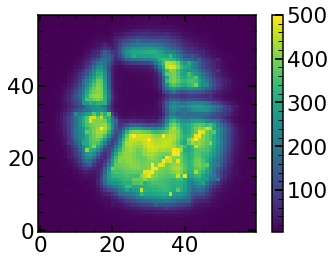

In [57]:
plt.imshow(list_of_var_images[0],vmax=500)
plt.colorbar()

In [35]:
array_of_var_sum=np.array(list(map(np.sum,list_of_var_images)))
index_of_max_var_sum=np.where(array_of_var_sum==np.min(array_of_var_sum))[0][0]
# find what variance selectes top 20% of pixels
# this is done to weight more the images in focus and less the image out of focus in the 
# final likelihood result
quantile_08_focus=np.quantile(list_of_sci_images[index_of_max_var_sum],0.8)




list_of_var_sums=[]
for i in range(9):
    var_image_masked=list_of_var_images[i]
    sci_image=list_of_sci_images[i]
    

    mean_value_of_background=np.mean([np.median(sci_image),np.median(sci_image),\
                      np.median(sci_image),np.median(sci_image)])*3
            
    #flux_mask=sci_image>(mean_value_of_background)
    #var_image_masked=var_image[flux_mask]
    
    var_image_masked_without_nan = var_image_masked.ravel()[var_image_masked.ravel()>quantile_08_focus]
    print('number of pixels considering in image '+str(i)+': '+str(var_image_masked_without_nan.shape[0]))
    var_sum=-(1/2)*(np.sum(np.log(2*np.pi*var_image_masked_without_nan)))
    list_of_var_sums.append(var_sum)
    
array_of_var_sum=np.array(list_of_var_sums)
max_of_array_of_var_sum=np.max(array_of_var_sum)
print(array_of_var_sum)
renormalization_of_var_sum=array_of_var_sum/max_of_array_of_var_sum

renormalization_of_var_sum

array_of_var_sum=np.array(list(map(np.sum,list_of_var_images)))
index_of_max_var_sum=np.where(array_of_var_sum==np.min(array_of_var_sum))[0][0]
# find what variance selectes top 20% of pixels
# this is done to weight more the images in focus and less the image out of focus in the 
# final likelihood result

quantile_08_focus=np.quantile(list_of_sci_images[index_of_max_var_sum],0.8)
'model pixels with a flux larger than?: '+str(quantile_08_focus)

number of pixels considering in image 0: 2294
number of pixels considering in image 1: 1798
number of pixels considering in image 2: 1323
number of pixels considering in image 3: 99
number of pixels considering in image 4: 42
number of pixels considering in image 5: 78
number of pixels considering in image 6: 1154
number of pixels considering in image 7: 1548
number of pixels considering in image 8: 1994
[-7429.56689453 -5818.91748047 -4309.50683594  -301.5012207
  -124.15708923  -235.02693176 -3770.04248047 -5072.56835938
 -6555.05712891]


'model pixels with a flux larger than?: 12.174482917785651'

-1384.1662944042646
array_of_single_res: [-83715.2109375  -41634.85546875 -16006.99707031  -5919.41503906
  -2018.79040527  -3986.23828125 -27904.40234375 -44162.05078125
 -60553.9609375 ]
renormalization factors: [59.84005376 46.86738    34.71011492  2.42838506  1.          1.89298036
 30.3651004  40.85605092 52.79647879]


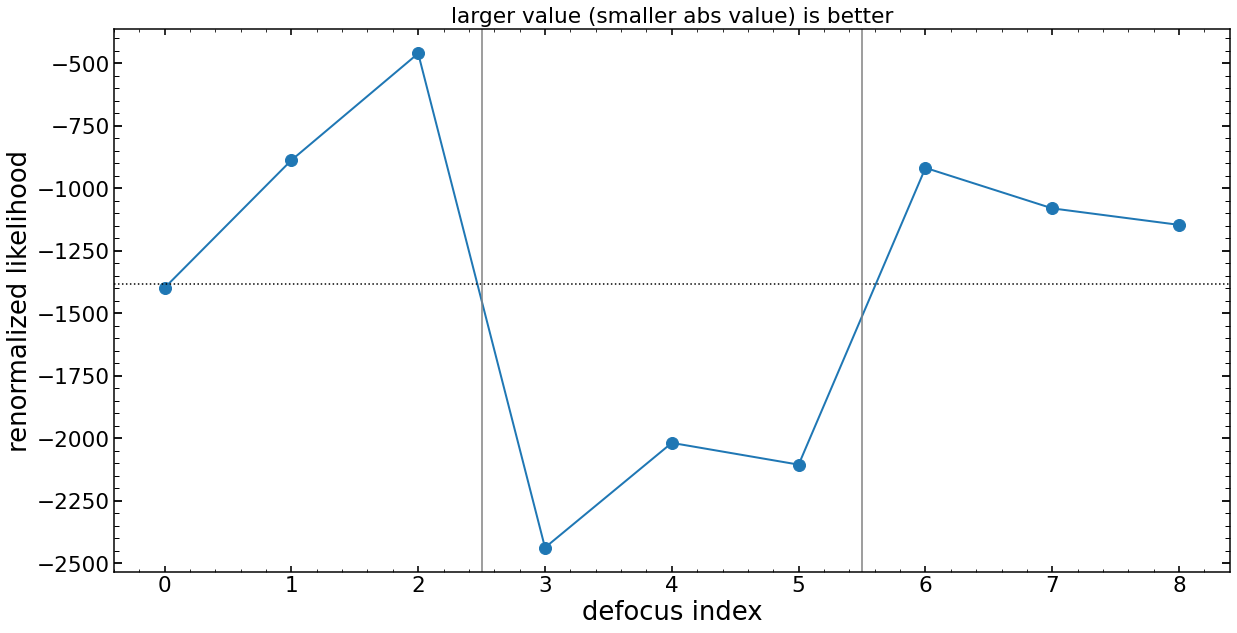

In [36]:
# shows the reported likelihood for each image, after division by the renormalization factor
# smaller absolute values is better
# dotted lien shows the mean reported value

plt.figure(figsize=(20,10))
array_of_single_res=np.array(list_of_single_res)

mean_res_of_multi_same_spot=np.mean(array_of_single_res/renormalization_of_var_sum)
print(mean_res_of_multi_same_spot)
print('array_of_single_res: '+str(array_of_single_res))
print('renormalization factors: '+str(renormalization_of_var_sum))
plt.plot(array_of_single_res/renormalization_of_var_sum,marker='o',lw=2,ms=12)
plt.xlabel('defocus index')
plt.ylabel('renormalized likelihood')
plt.axhline(mean_res_of_multi_same_spot,color='black',ls=":")
plt.axvline(2.5,color='gray')
plt.title('larger value (smaller abs value) is better')
plt.axvline(5.5,color='gray')

In [43]:
"""
-1380.846598202445
array_of_single_res: [-84607.3046875  -41977.2734375  -16216.77636719  -5851.328125
  -2012.60107422  -3942.59765625 -27768.34375    -44224.47265625
 -60664.78125   ]
renormalization factors: [59.84005376 46.86738    34.71011492  2.42838506  1.          1.89298036
 30.3651004  40.85605092 52.79647879]
 """

'\n-1380.846598202445\narray_of_single_res: [-84607.3046875  -41977.2734375  -16216.77636719  -5851.328125\n  -2012.60107422  -3942.59765625 -27768.34375    -44224.47265625\n -60664.78125   ]\nrenormalization factors: [59.84005376 46.86738    34.71011492  2.42838506  1.          1.89298036\n 30.3651004  40.85605092 52.79647879]\n '

In [37]:
minchain=list_of_minchain[4]

print('minchain.shape '+str(minchain.shape))

    
dfz11 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns22[0:8])
print(dfz11)
print('##############################################')
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][8:19]]),columns=columns22[8:19])
print(dfz22)

print('')
#dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][19:len(columns)]]),columns=columns[19:])
print('##############################################')
dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][19:19+6]]),columns=columns22[19:19+6])
print(dfglobal1)
print('##############################################')
dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][25:25+4]]),columns=columns22[25:25+4])
print(dfglobal2)
print('##############################################')
dfglobal3 = pd.DataFrame(np.array([np.array([minchain])[0][29:29+5]]),columns=columns22[29:29+5])
print(dfglobal3)
print('##############################################')
dfglobal4 = pd.DataFrame(np.array([np.array([minchain])[0][34:41]]),columns=columns22[34:41])
print(dfglobal4)

minchain.shape (76,)
         z4        z5        z6        z7        z8        z9       z10  \
0  0.072409 -0.850683 -0.567996 -0.281229  0.326141 -0.273918 -0.564951   

        z11  
0  0.314215  
##############################################
        z12       z13       z14       z15       z16       z17       z18  \
0  0.008088  0.157788 -0.023828  0.057348  0.000257  0.033988  0.016402   

        z19       z20       z21       z22  
0 -0.020875 -0.040087  0.029526  0.019653  

##############################################
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy
0  0.675613   0.109476 -0.165694  0.250664  0.064657     0.081968
##############################################
     wide_0   wide_23  wide_43  misalign
0  0.109833  0.192756      0.0  2.031478
##############################################
    x_fiber   y_fiber  effective_radius_illumination  frd_sigma  \
0 -0.051419 -0.038229                       0.895029   0.041847   

   frd_lorentz_factor  

(-2.8, -1.5)

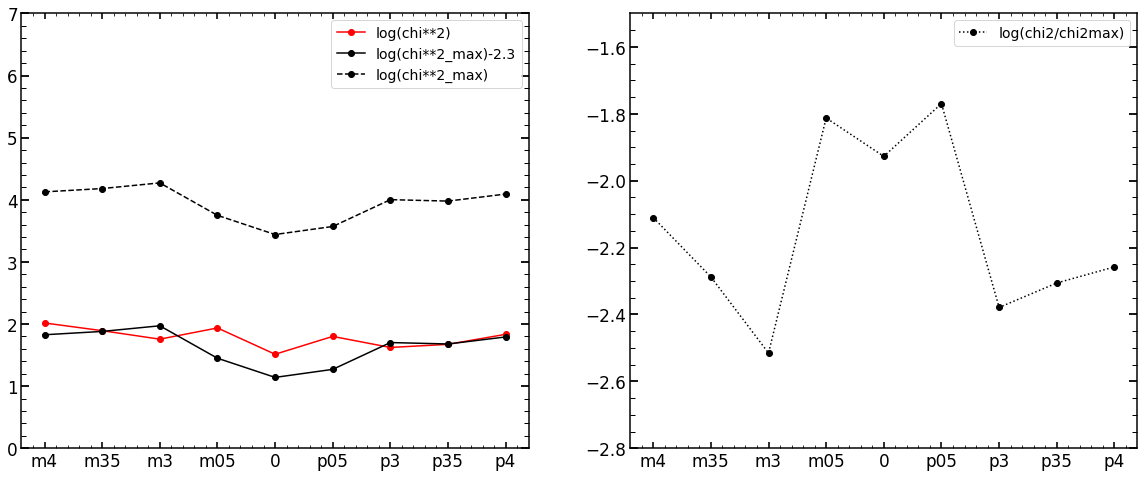

In [45]:
chi_results_array=np.array(res_multi[4])

plt.figure(figsize=(20,8))

plt.subplot(121)

plt.plot(np.log10(chi_results_array[:,2]),color='red',label='log(chi**2)',marker='o')
plt.plot(np.log10(chi_results_array[:,3])-2.3,color='black',label='log(chi**2_max)-2.3',marker='o')
plt.plot(np.log10(chi_results_array[:,3]),color='black',label='log(chi**2_max)',marker='o',ls='--')
plt.ylim(0,7)
plt.xticks(np.arange(0,len(list_of_defocuses_input_long),1),list_of_defocuses_input_long)
plt.legend()
plt.subplot(122)

plt.plot(np.log10(chi_results_array[:,2]/chi_results_array[:,3]),color='black',label='log(chi2/chi2max)',marker='o',ls=':')
plt.legend()
plt.xticks(np.arange(0,len(list_of_defocuses_input_long),1),list_of_defocuses_input_long)
plt.ylim(-2.8,-1.5)

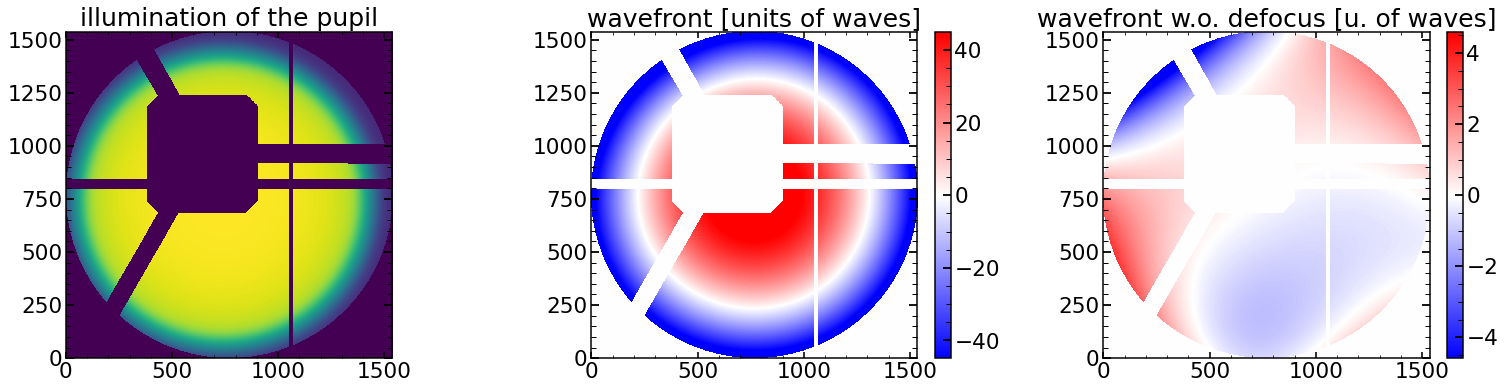

In [38]:
single_analysis.illumination_wavefront_plot()

Science image shape is: (60, 60)
Top left pixel value of the science image is: 5.84908
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 5.4849067
Mask image shape is: (60, 60)
Sum of mask image is: 0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.41b
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56
fraction of chi2 due to 1% of pixels: 0.119140685
chi**2 max reduced is: 5648.1694
chi**2 reduced is: 57.95173 for log improvment: -1.9888413
---------------------
chi**2 reduced within mask area is: 57.95173
---------------------
chi**2 max reduced within flux mask area is: 13391.023
chi**2 reduced within flux mask area is: 104.45881 for log improvment: -2.1078687
---------------------
Abs of residual divided by total flux is: 0.07346229
Abs of residual divided by largest value of a 

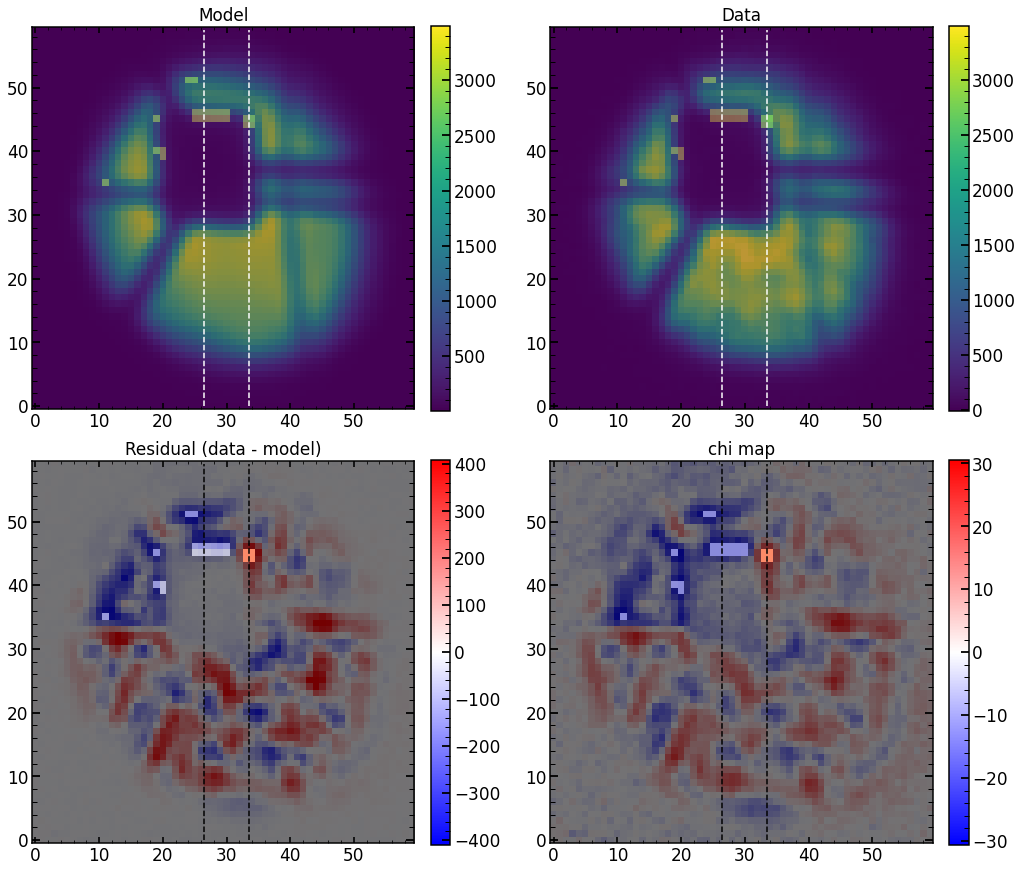

In [39]:
index_of_single_image=0

#
model_single_image = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],\
                                   dithering=1,save=0,zmax=56,verbosity=1,\
                                   double_sources=double_sources,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)

custom_var=model_single_image.create_custom_var(modelImg=list_of_single_model_image[index_of_single_image],sci_image=list_of_sci_images[index_of_single_image],
                                    var_image=list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image])

matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot(custom_model_image=list_of_single_model_image[index_of_single_image],custom_mask=list_of_mask_images[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image],\
                                             show_flux_mask=False,use_max_chi_scaling=True,use_max_flux_scaling=True,show_impact_pixels_mask=True)

# I can move to use custom_var within the analysis
#single_analysis.create_basic_comparison_plot(custom_model_image=list_of_single_model_image[index_of_single_image],custom_mask=list_of_mask_images[index_of_single_image],\
#                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=custom_var,\
#                                             show_flux_mask=False,use_max_chi_scaling=True,use_max_flux_scaling=False)

chi**2 max reduced is: 5648.1694
chi**2 reduced is: 57.95173
Abs of residual divided by total flux is: 0.07346229
Abs of residual divided by largest value of a flux in the image is: 0.16377683


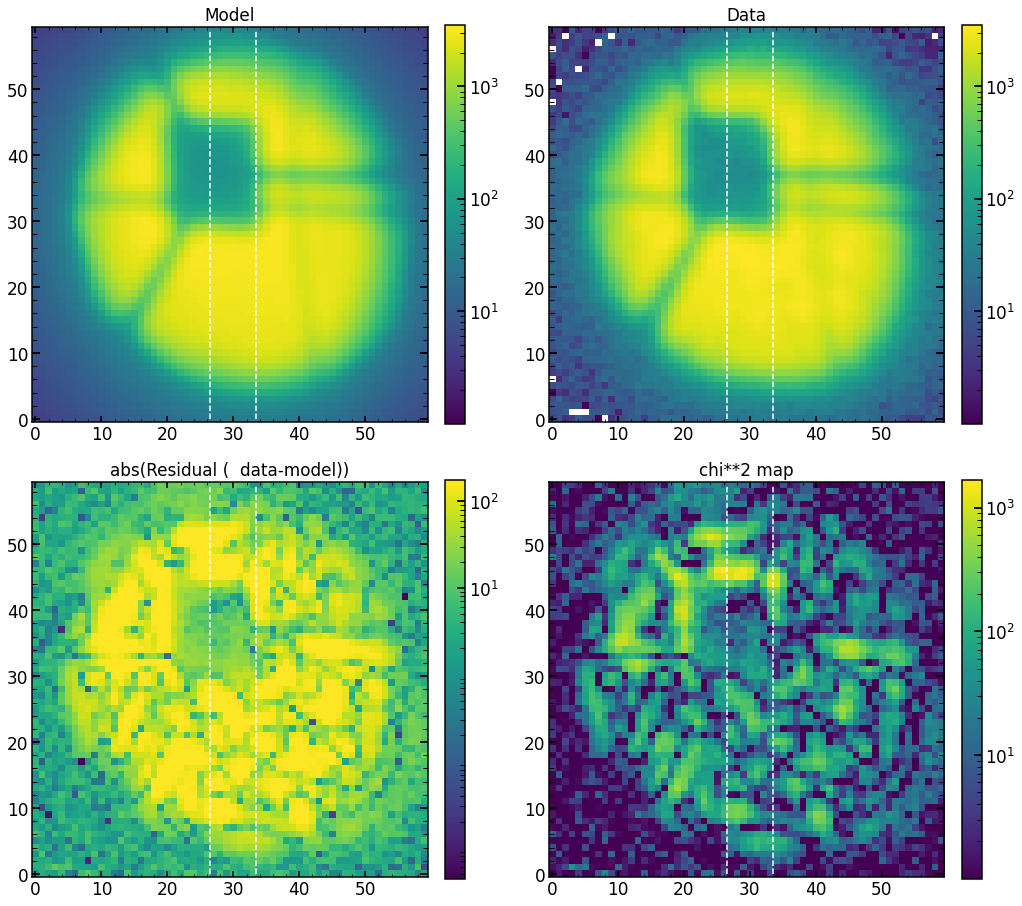

In [56]:
single_analysis.create_basic_comparison_plot_log(custom_model_image=list_of_single_model_image[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image],\
                                                show_flux_mask=False)

57.95173
chi**2 reduced is: 57.95173
Abs of residual divided by total flux is: 0.07346229
Abs of residual divided by largest value of a flux in the image is: 0.16377683


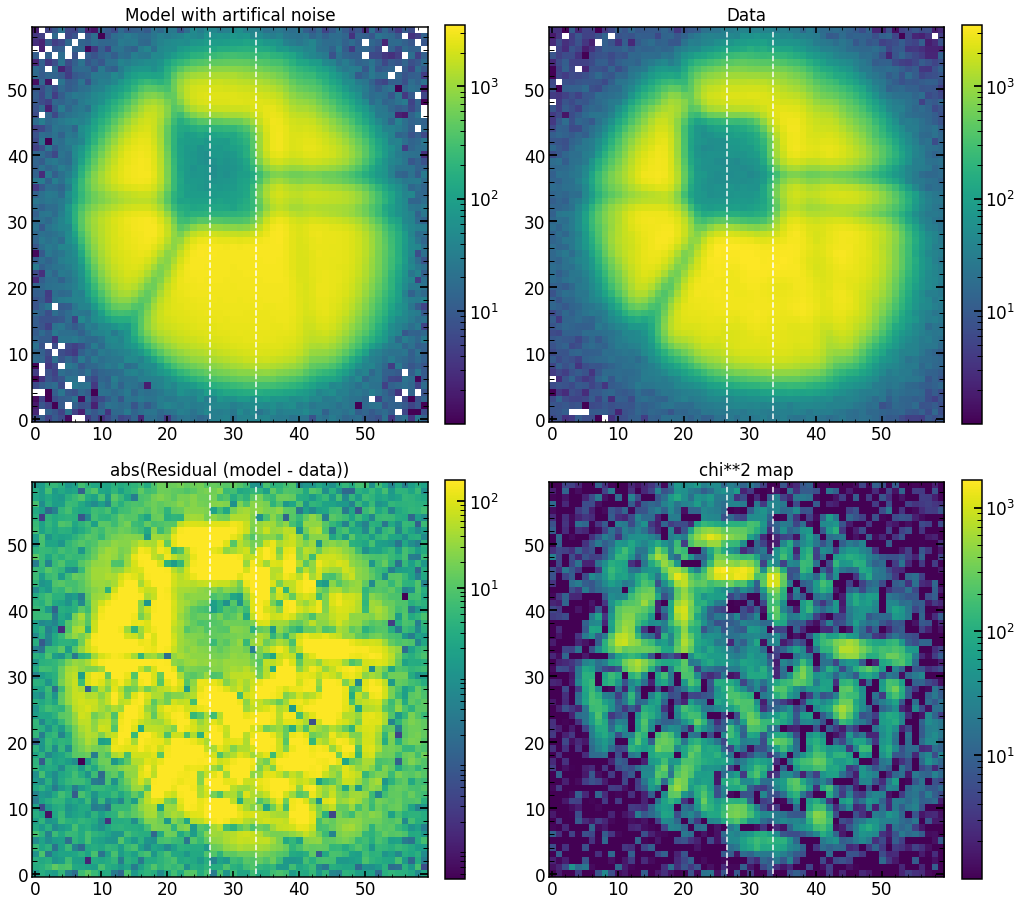

In [57]:
single_analysis.create_basic_comparison_plot_log_artifical(custom_model_image=list_of_single_model_image[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image])

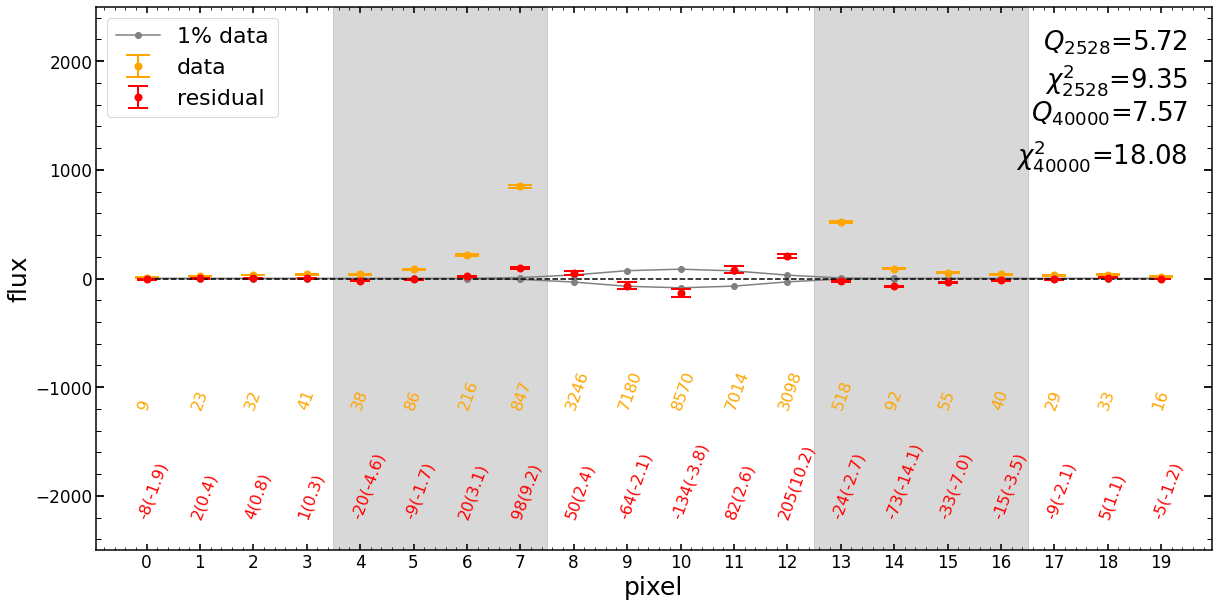

In [54]:
index_of_single_image=4
plot_1D_residual(sci_image=list_of_sci_images[index_of_single_image],var_image=list_of_var_images[index_of_single_image],model_image=list_of_single_model_image[index_of_single_image])

In [ ]:
res_iapetus=list_of_single_model_image[index_of_single_image]
sci_image=list_of_sci_images[index_of_single_image]
var_image=list_of_var_images[index_of_single_image]

chi2_image=(sci_image-res_iapetus)**2/((1)*var_image)

mask_most_impactful_pixels=np.zeros(sci_image.shape)
mask_most_impactful_pixels[chi2_image>(np.quantile(chi2_image.ravel(),0.99))]=1

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(chi2_image)


In [131]:
        mean_value_of_background=np.mean([np.median(sci_image),np.median(sci_image),\
                              np.median(sci_image),np.median(sci_image)])*3
            
        flux_mask=sci_image>(mean_value_of_background)
chi2_image>(np.quantile(chi2_image[flux_mask].ravel(),0.99))

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [134]:
np.sum(chi2_image[flux_mask].ravel()[chi2_image[flux_mask].ravel()>np.quantile(chi2_image[flux_mask].ravel(),0.99)])

12321.467

In [135]:
np.sum(chi2_image[flux_mask].ravel())

102803.06

In [109]:
np.cumsum(chi2_image.ravel()[chi2_image.ravel()>(np.quantile(chi2_image.ravel(),0.90))])

array([  125.60808,   228.16403,   338.96503,   464.51276,   617.93066,
         734.65125,   849.4882 ,   955.6003 ,  1095.3105 ,  1269.8049 ,
        1421.1909 ,  1568.2648 ,  1689.2648 ,  1943.858  ,  2168.4924 ,
        2295.8906 ,  2441.2334 ,  2775.7283 ,  2956.913  ,  3059.6084 ,
        3181.128  ,  3418.969  ,  3536.5405 ,  3665.0771 ,  3772.845  ,
        3966.2478 ,  4072.6973 ,  4486.233  ,  4862.4565 ,  4978.5547 ,
        5092.0884 ,  5193.9746 ,  5318.247  ,  5421.443  ,  5568.2227 ,
        5791.06   ,  5977.282  ,  6140.782  ,  6463.06   ,  7160.3877 ,
        7711.885  ,  7844.508  ,  8066.627  ,  8259.768  ,  8446.327  ,
        8744.759  ,  9102.661  ,  9511.295  ,  9645.293  ,  9802.51   ,
       10126.046  , 11081.354  , 11915.572  , 12191.504  , 12302.292  ,
       12416.542  , 12535.637  , 12988.142  , 13575.013  , 13763.703  ,
       13948.564  , 14418.145  , 15363.473  , 16094.439  , 16251.441  ,
       16358.376  , 16936.79   , 17396.744  , 17669.564  , 17965

# PIPE2D - 694

In [9]:
import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
from Residual_1D_module import * 
from Zernike_Analysis_Module import *


In [10]:
DATAFRAMES_FOLDER='/Users/nevencaplar/Documents/PFS/Fit_Results/Jan2921/'

with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ar_from_Jan2921.pkl', 'rb') as f:
    results_of_fit_many_Ar_from_Jan29=pickle.load(f)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ne_from_Jan2921.pkl', 'rb') as f:
    results_of_fit_many_Ne_from_Jan29=pickle.load(f)    
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Kr_from_Jan2921.pkl', 'rb') as f:
    results_of_fit_many_Kr_from_Jan29=pickle.load(f)    

In [11]:
index_Ar=results_of_fit_many_Ar_from_Jan29['0'].index[np.log10(results_of_fit_many_Ar_from_Jan29['0']['chi2'].values/results_of_fit_many_Ar_from_Jan29['0']['chi2max'].values)==np.min(np.log10(results_of_fit_many_Ar_from_Jan29['0']['chi2'].values/results_of_fit_many_Ar_from_Jan29['0']['chi2max'].values))][0]
results_of_fit_many_Ar_from_Jan29['0'].loc[index_Ar]

z4             0.583624
z5             0.096308
z6             0.091398
z7             0.263171
z8             0.320398
               ...     
z54            0.001800
z55            0.005206
z56           -0.002941
chi2          25.140766
chi2max    26446.005859
Name: 17, Length: 78, dtype: float64

In [12]:
np.log10(results_of_fit_many_Ne_from_Jan29['0']['chi2'].values/results_of_fit_many_Ne_from_Jan29['0']['chi2max'].values)

array([-3.00806192, -2.66874003, -3.06738118, -3.10539325, -3.07116454,
       -2.47254036, -3.31791156, -2.77754443, -2.52807131, -2.89038856,
       -2.72517208, -2.74621489, -2.87233488, -2.55855649, -1.82500239,
       -2.69025609, -2.96441311, -2.70881825, -2.97735303, -2.38059773,
       -2.87933653, -2.93894102, -2.77901462, -2.86100907, -2.77652329,
       -3.11103935, -2.99384834, -2.92132949, -2.8154349 , -2.93036988,
       -2.40417206, -2.78181689, -2.84983238, -2.90295593, -2.37601667,
       -2.11284027, -2.8314205 , -2.86290834, -2.846861  , -2.95046778,
       -2.71094695, -3.07814674, -2.71701931, -2.9773274 , -2.83557419,
       -3.34638737, -2.97153558, -2.85914061, -2.96428887, -2.793518  ])

In [13]:
np.log10(results_of_fit_many_Kr_from_Jan29['0']['chi2'].values/results_of_fit_many_Kr_from_Jan29['0']['chi2max'].values)

array([-2.71640177, -2.6311193 , -2.60856308, -2.39812688, -2.61168323,
       -2.56562577, -2.64008286, -2.31350847, -2.56144452, -2.6611007 ,
       -2.5859382 , -2.31712543, -2.4566981 , -2.67333607, -2.67230274,
       -2.66437244, -2.37495001, -2.57205723, -2.24582693, -2.38324195,
       -2.62279973, -2.41937831, -2.62530361, -2.75398965, -2.49577041,
       -2.25643948, -2.58337808, -2.62238771, -2.34785296, -2.75781324,
       -2.66276193, -2.53174245, -2.2918885 , -2.45378403, -2.81628106])

In [14]:
finalAr=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalAr_Feb2020",allow_pickle=True)
finalNe=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalNe_Feb2020",allow_pickle=True)
finalKr=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalKr_Feb2020",allow_pickle=True)

In [15]:
date='Jan2920'
#obs=34313
#obs_int=int(obs)
single_number='17'
image_index=int(single_number)
eps=6
arc='Ar'
dataset=6

if arc=='Ar':
    obs=34341+96
    finalArc=finalAr
if arc=='Ne':
    obs=34217+96 
    finalArc=finalNe
if arc=='Kr':
    obs=34561+96
    finalArc=finalKr



list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

finalArc.loc[int(single_number)]

fiber                    63
xc                      463
yc                     1631
wavelength        763.74286
close                     1
lamp                     Ar
xc_effective            463
second_offset             0
second_ratio              0
second2_offset            0
second2_ratio             0
Name: 17, dtype: object

STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 17
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0.0 0.0]


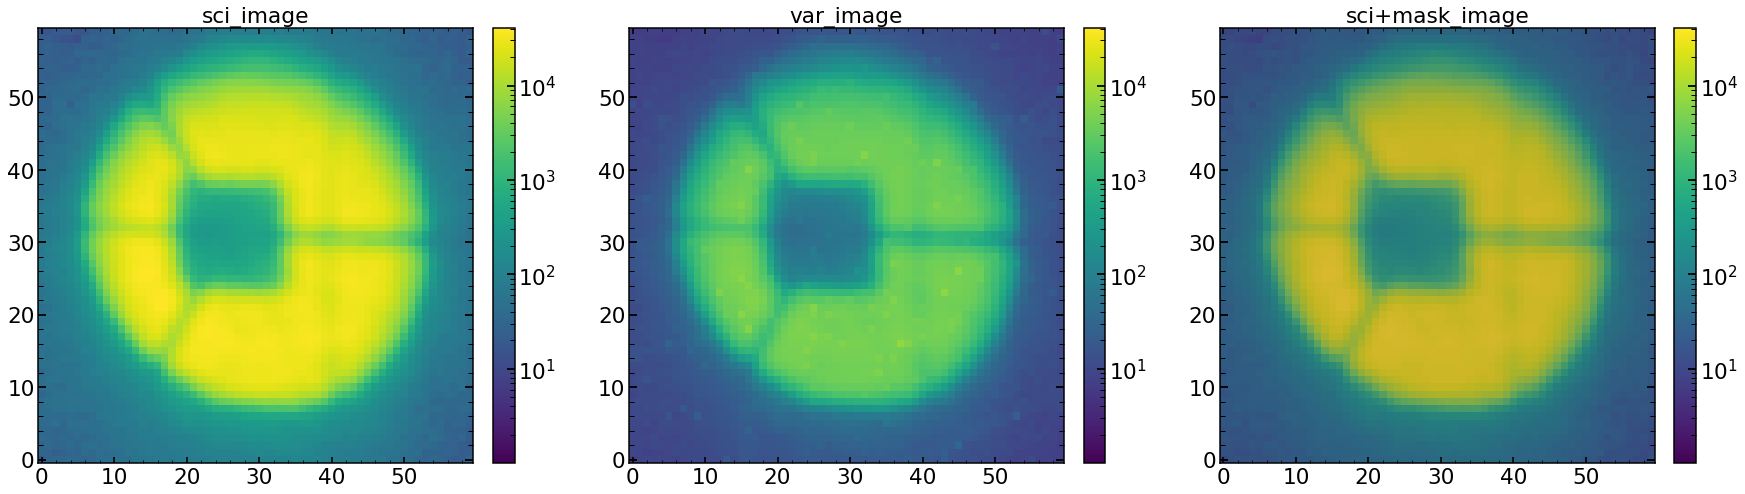

In [17]:
single_analysis=Zernike_Analysis(date=date,obs='m4',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                 list_of_defocuses=list_of_defocuses_input_long)
single_analysis.create_basic_data_image()

117
1


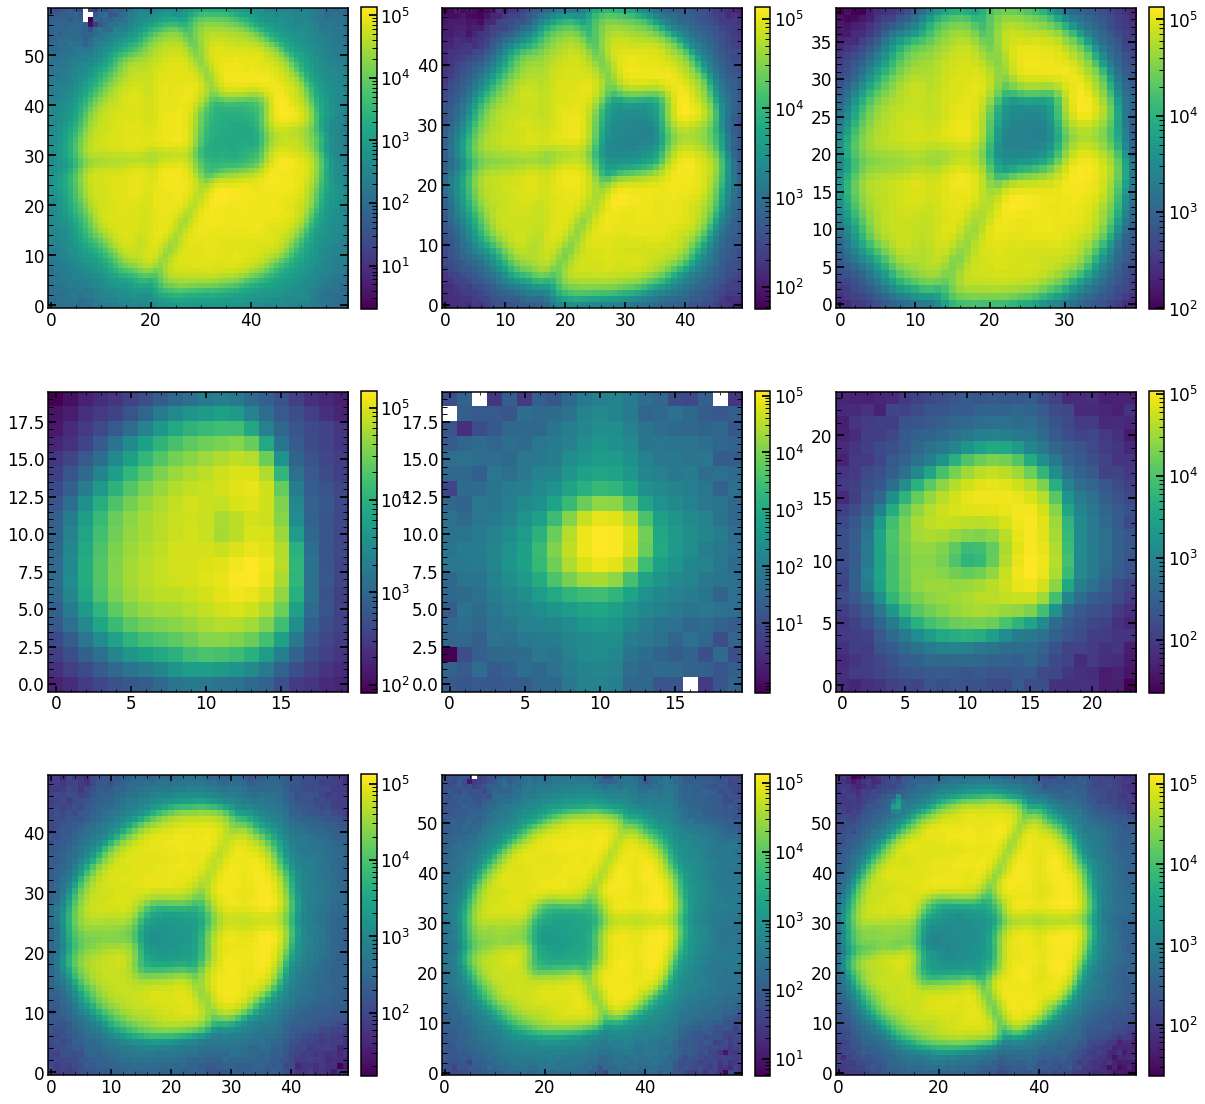

In [18]:
matplotlib.rcParams.update({'font.size': 14})

#image_index=87

image_index=117

print(image_index)
print(finalAr.loc[image_index]['close'])

run_1=19238+6
run_2=19238+12
run_3=19238+18
run_4=19238+54-12
run_5=19238+54
run_6=19238+54+12
run_7=19238+54+36
run_8=19238+54+42
run_9=19238+54+48


sci_1_LAM=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_1)+str(image_index)+'HgAr_Stacked.npy')
sci_2_LAM=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_2)+str(image_index)+'HgAr_Stacked.npy')
sci_3_LAM=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_3)+str(image_index)+'HgAr_Stacked.npy')
sci_4_LAM=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_4)+str(image_index)+'HgAr_Stacked.npy')
sci_5_LAM=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_5)+str(image_index)+'HgAr_Stacked.npy')
sci_6_LAM=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_6)+str(image_index)+'HgAr_Stacked.npy')
sci_7_LAM=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_7)+str(image_index)+'HgAr_Stacked.npy')
sci_8_LAM=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_8)+str(image_index)+'HgAr_Stacked.npy')
sci_9_LAM=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_9)+str(image_index)+'HgAr_Stacked.npy')

plt.figure(figsize=(20,20))
plt.subplot(331)
plt.imshow(sci_1_LAM,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(332)
plt.imshow(sci_2_LAM,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(333)
plt.imshow(sci_3_LAM,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(334)
plt.imshow(sci_4_LAM,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(335)
plt.imshow(sci_5_LAM,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(336)
plt.imshow(sci_6_LAM,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(337)
plt.imshow(sci_7_LAM,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(338)
plt.imshow(sci_8_LAM,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(339)
plt.imshow(sci_9_LAM,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

1


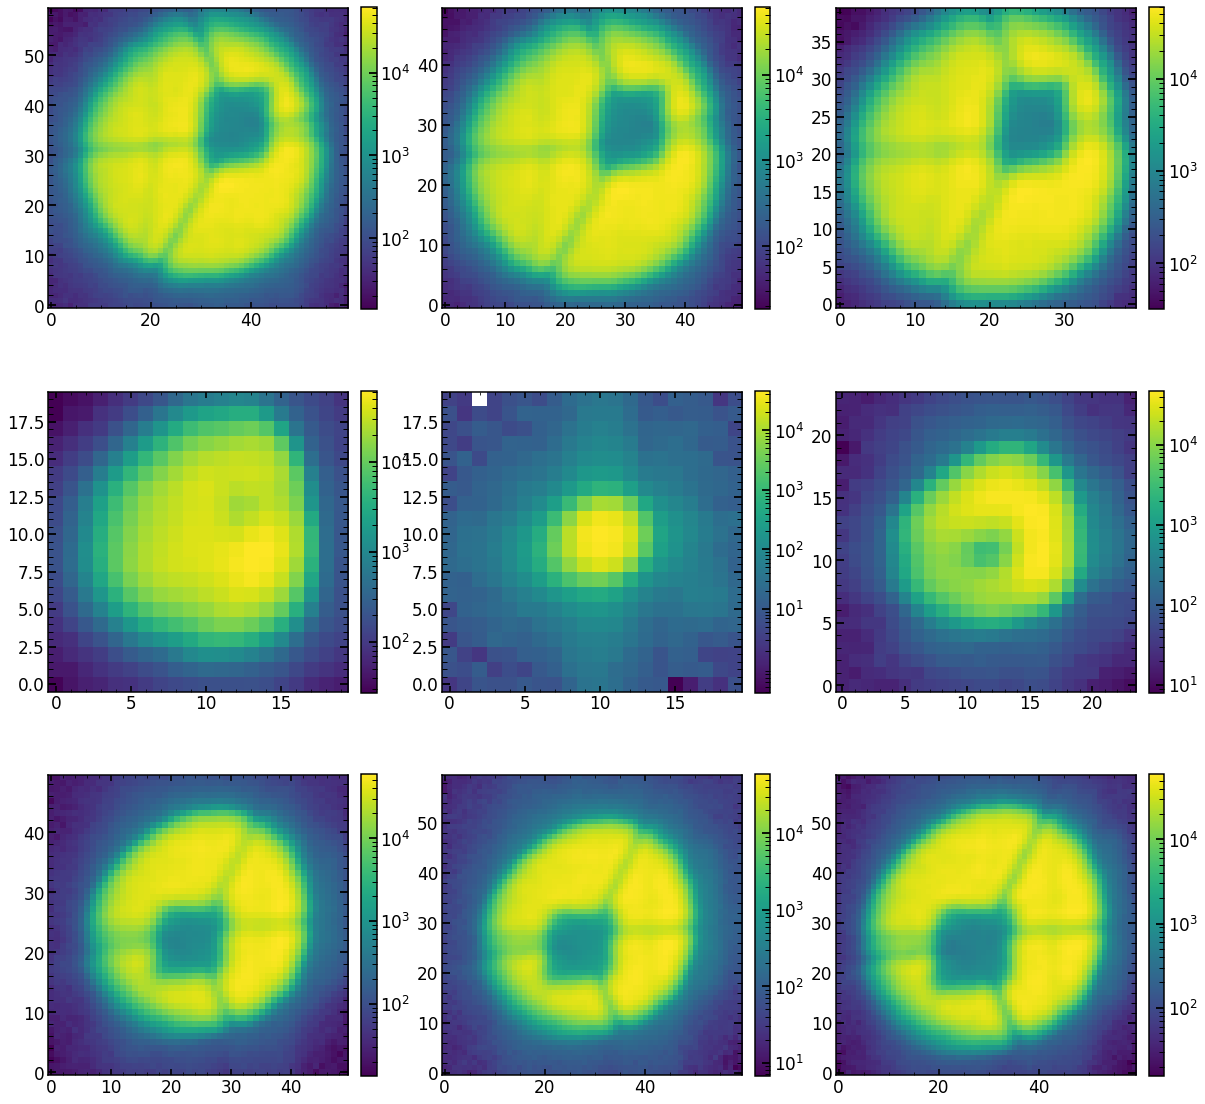

In [20]:
matplotlib.rcParams.update({'font.size': 14})



print(finalAr.loc[image_index]['close'])

run_1=34341+0
run_2=34341+6
run_3=34341+12
run_4=34341+48-12
run_5=34341+48
run_6=34341+48+12
run_7=34341+48+36
run_8=34341+48+42
run_9=34341+48+48


sci_1=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/sci"+str(run_1)+str(image_index)+'Ar_Stacked.npy')
sci_2=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/sci"+str(run_2)+str(image_index)+'Ar_Stacked.npy')
sci_3=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/sci"+str(run_3)+str(image_index)+'Ar_Stacked.npy')
sci_4=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/sci"+str(run_4)+str(image_index)+'Ar_Stacked.npy')
sci_5=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/sci"+str(run_5)+str(image_index)+'Ar_Stacked.npy')
sci_6=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/sci"+str(run_6)+str(image_index)+'Ar_Stacked.npy')
sci_7=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/sci"+str(run_7)+str(image_index)+'Ar_Stacked.npy')
sci_8=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/sci"+str(run_8)+str(image_index)+'Ar_Stacked.npy')
sci_9=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/sci"+str(run_9)+str(image_index)+'Ar_Stacked.npy')

plt.figure(figsize=(20,20))
plt.subplot(331)
plt.imshow(sci_1,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(332)
plt.imshow(sci_2,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(333)
plt.imshow(sci_3,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(334)
plt.imshow(sci_4,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(335)
plt.imshow(sci_5,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(336)
plt.imshow(sci_6,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(337)
plt.imshow(sci_7,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(338)
plt.imshow(sci_8,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(339)
plt.imshow(sci_9,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [72]:

image_index=117

print(image_index)
print(finalAr.loc[image_index])

run_1=21346+6
run_9=21346+54+48


sci_1_LAM=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/sci"+str(run_1)+str(image_index)+'HgAr_Stacked.npy')
sci_9_LAM=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/sci"+str(run_9)+str(image_index)+'HgAr_Stacked.npy')


run_1=34341+0
run_9=34341+48+48
sci_1=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/sci"+str(run_1)+str(image_index)+'Ar_Stacked.npy')
sci_9=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/sci"+str(run_9)+str(image_index)+'Ar_Stacked.npy')

117
fiber                  650
xc                    4008
yc                    3393
wavelength        912.5693
close                    1
lamp                    Ar
xc_effective          4077
second_offset            0
second_ratio             0
second2_offset           0
second2_ratio            0
Name: 117, dtype: object


Text(0.5, 1.0, 'Subaru data, defocus=4 mm, fiber=650, vw=912.569 nm')

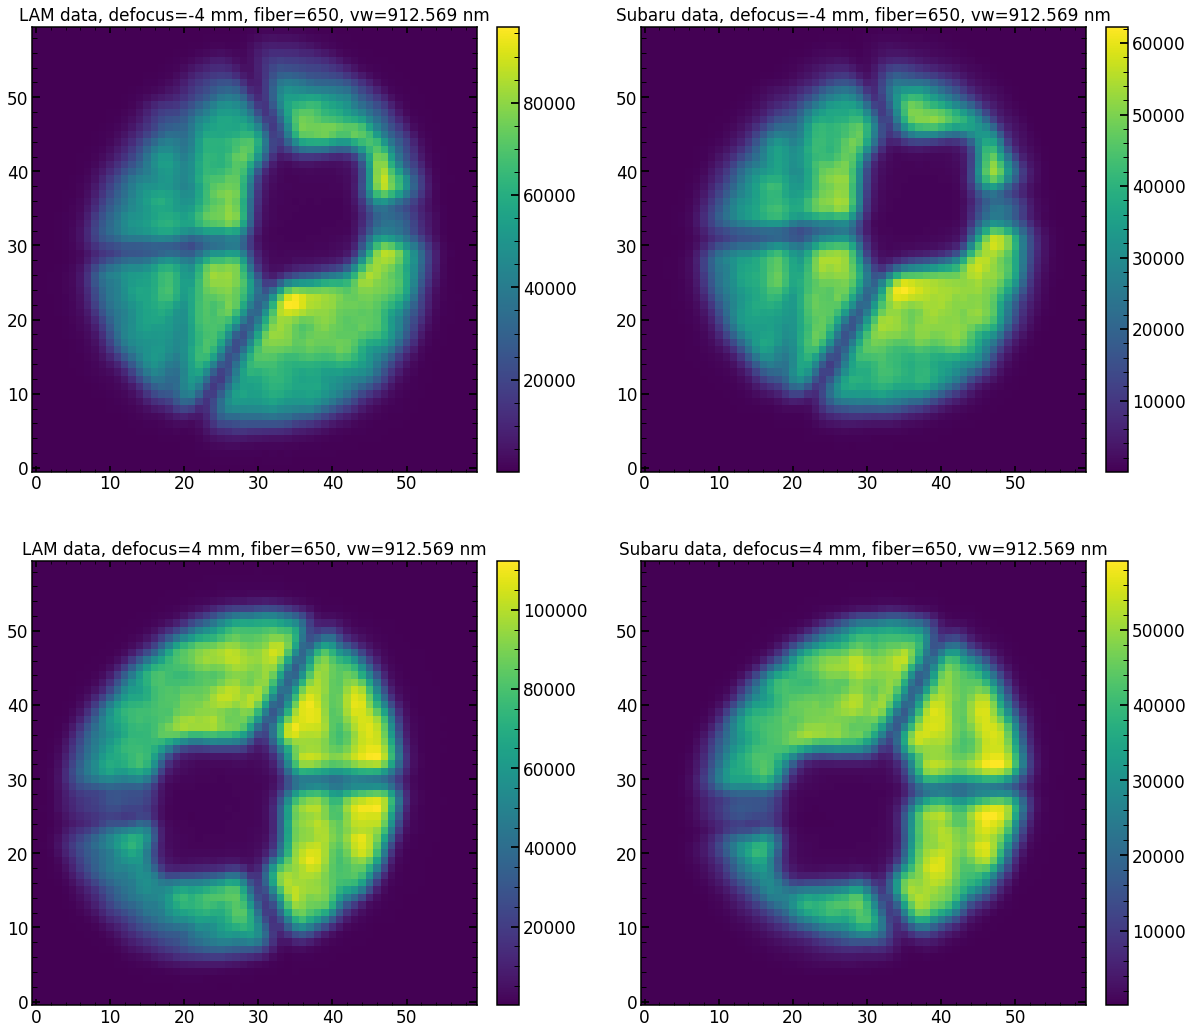

In [74]:

plt.figure(figsize=(20,18))
plt.subplot(221)

plt.imshow(sci_1_LAM,vmax=np.max(sci_1_LAM),vmin=np.max(sci_1_LAM)/1000)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.title('LAM data, defocus=-4 mm, fiber=650, vw=912.569 nm')

plt.subplot(222)

plt.imshow(sci_1,vmax=np.max(sci_1),vmin=np.max(sci_1)/1000)

cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Subaru data, defocus=-4 mm, fiber=650, vw=912.569 nm')


plt.subplot(223)
plt.imshow(sci_9_LAM,vmax=np.max(sci_9_LAM),vmin=np.max(sci_9_LAM)/1000)

cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.title('LAM data, defocus=4 mm, fiber=650, vw=912.569 nm')


plt.subplot(224)

plt.imshow(sci_9,vmax=np.max(sci_9),vmin=np.max(sci_9)/1000)

cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Subaru data, defocus=4 mm, fiber=650, vw=912.569 nm')

56
fiber                  339
xc                    1610
yc                    2635
wavelength        852.4029
close                    1
lamp                    Ar
xc_effective          1610
second_offset            0
second_ratio             0
second2_offset           0
second2_ratio            0
Name: 56, dtype: object
exposure_defocus_1_LAM: -4.0
exposure_defocus_9_LAM: 4.0


Text(0.5, 1.0, 'Subaru data, defocus=4 mm, fiber=339, vw=852.40 nm')

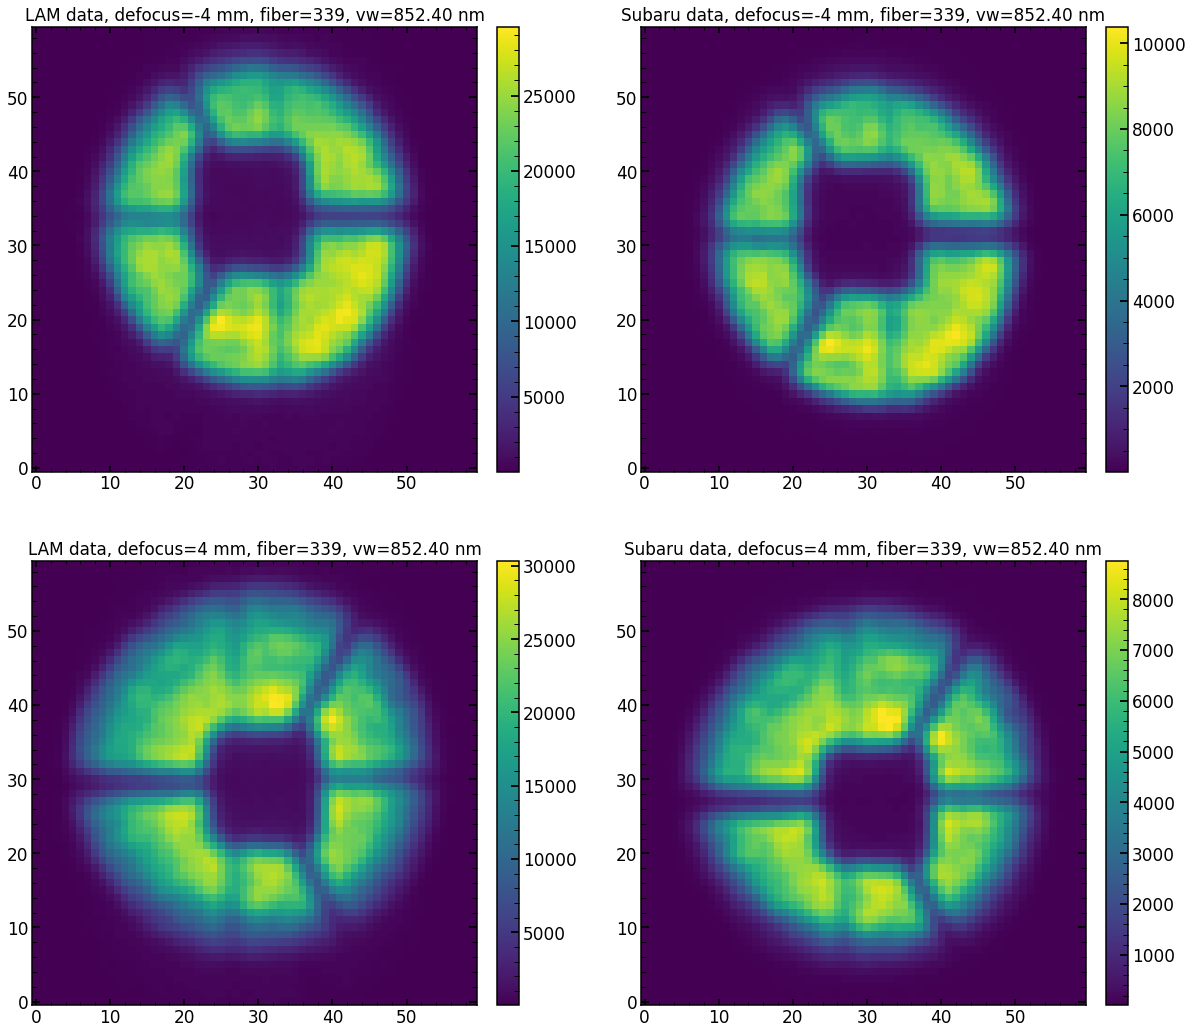

In [87]:

image_index=56

print(image_index)
print(finalAr.loc[image_index])

run_1=21346+6
run_9=21346+54+48


sci_1_LAM=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_1)+str(image_index)+'HgAr_Stacked.npy')
sci_9_LAM=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/sci"+str(run_9)+str(image_index)+'HgAr_Stacked.npy')

sci_1_LAM_raw=fits.open('/Volumes/Saturn_USA/PFS/ReducedData/Jun_2019_run1/rerun/rerun_1/detrend/calExp/2019-07-26/v00'+str(run_1)+'/calExp-LA0'+str(run_1)+'r1.fits')
exposure_defocus_1_LAM=np.round(sci_1_LAM_raw[0].header['W_ENFCAX'],2)
print('exposure_defocus_1_LAM: '+str(exposure_defocus_1_LAM))
sci_9_LAM_raw=fits.open('/Volumes/Saturn_USA/PFS/ReducedData/Jun_2019_run1/rerun/rerun_1/detrend/calExp/2019-07-26/v00'+str(run_9)+'/calExp-LA0'+str(run_9)+'r1.fits')
exposure_defocus_9_LAM=np.round(sci_9_LAM_raw[0].header['W_ENFCAX'],2)
print('exposure_defocus_9_LAM: '+str(exposure_defocus_9_LAM))

run_1=34341+0
run_9=34341+48+48
sci_1=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/sci"+str(run_1)+str(image_index)+'Ar_Stacked.npy')
sci_9=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/sci"+str(run_9)+str(image_index)+'Ar_Stacked.npy')


plt.figure(figsize=(20,18))
plt.subplot(221)

plt.imshow(sci_1_LAM,vmax=np.max(sci_1_LAM),vmin=np.max(sci_1_LAM)/1000)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.title('LAM data, defocus=-4 mm, fiber=339, vw=852.40 nm')

plt.subplot(222)

plt.imshow(sci_1,vmax=np.max(sci_1),vmin=np.max(sci_1)/1000)

cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Subaru data, defocus=-4 mm, fiber=339, vw=852.40 nm')


plt.subplot(223)
plt.imshow(sci_9_LAM,vmax=np.max(sci_9_LAM),vmin=np.max(sci_9_LAM)/1000)

cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.title('LAM data, defocus=4 mm, fiber=339, vw=852.40 nm')


plt.subplot(224)

plt.imshow(sci_9,vmax=np.max(sci_9),vmin=np.max(sci_9)/1000)

cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Subaru data, defocus=4 mm, fiber=339, vw=852.40 nm')

dx,dy0 3
center of sci_1_LAM_renormalized: (30.44656816730876, 31.4951159745555)
center of sci_1_LAM_renormalized moved: (30.44467047522903, 28.52897860023394)
center of sci_1: (30.56181699118944, 28.861129325904763)
(29.208646050629316, 31.803799520001462)
(29.20912009545198, 28.840988874622944)
(29.740706525102713, 29.79638225826512)


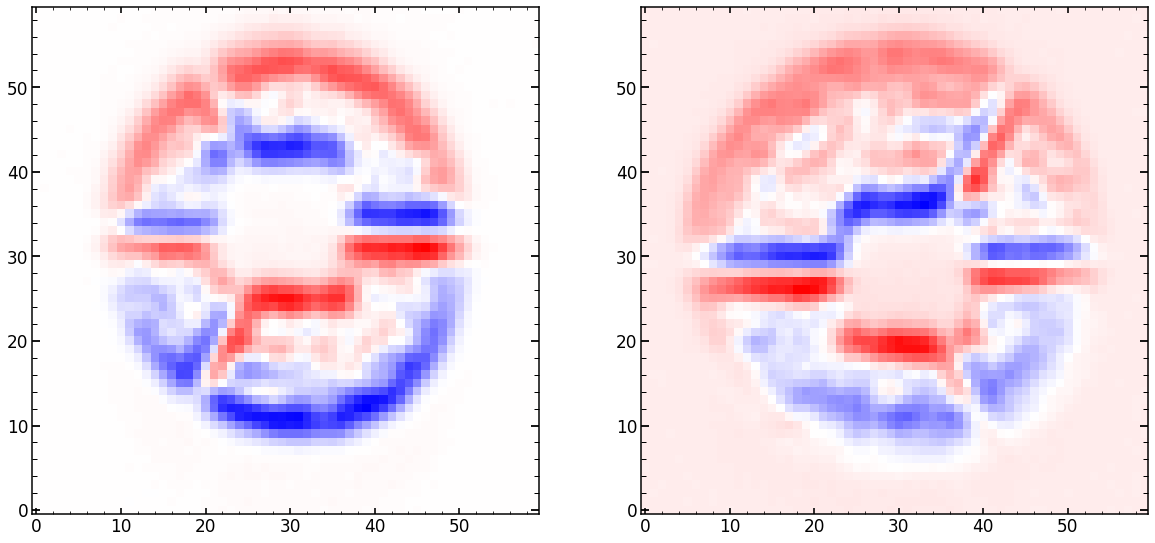

In [88]:
plt.figure(figsize=(20,10))

plt.subplot(121)
sci_1_LAM_renormalized=sci_1_LAM*np.sum(sci_1)/np.sum(sci_1_LAM)

dx,dy=np.array(find_centroid_of_flux(sci_1_LAM_renormalized))-np.array(find_centroid_of_flux(sci_1))
dx=int(np.round(dx))
dy=int(np.round(dy))

print('dx,dy'+str(dx)+' '+str(dy))
sci_1_LAM_renormalized_moved=np.zeros((60,60))
sci_1_LAM_renormalized_moved[0:60-dy,0:60-dx]=sci_1_LAM_renormalized[dy:60,dx:60]



print('center of sci_1_LAM_renormalized: '+str(find_centroid_of_flux(sci_1_LAM_renormalized)))
print('center of sci_1_LAM_renormalized moved: '+str(find_centroid_of_flux(sci_1_LAM_renormalized_moved)))

print('center of sci_1: '+str(find_centroid_of_flux(sci_1)))

plt.imshow(sci_1_LAM_renormalized-sci_1,cmap='bwr')


plt.subplot(122)
sci_9_LAM_renormalized=sci_9_LAM*np.sum(sci_9)/np.sum(sci_9_LAM)

sci_9_LAM_renormalized_moved=np.zeros((60,60))
sci_9_LAM_renormalized_moved[0:60-dy,0:60-dx]=sci_9_LAM_renormalized[dy:60,dx:60]

print(find_centroid_of_flux(sci_9_LAM_renormalized))
print(find_centroid_of_flux(sci_9_LAM_renormalized_moved))

print(find_centroid_of_flux(sci_9))

plt.imshow(sci_9_LAM_renormalized-sci_9,cmap='bwr')

Text(0.5, 1.0, 'cut along the middle of the image vertically, moved to roughly match, defocus=4mm, fiber=339, vw=852.40 nm')

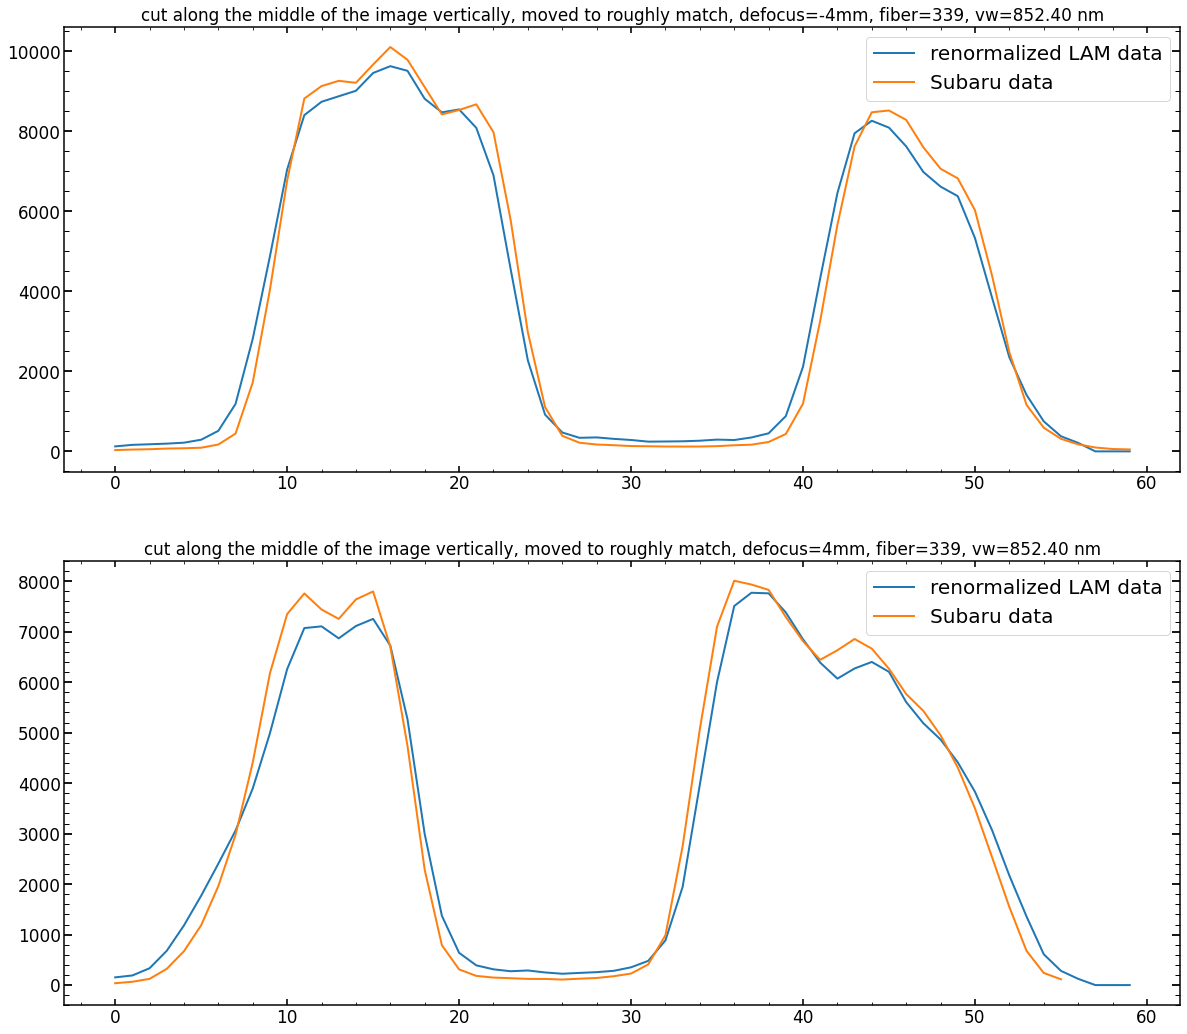

In [90]:
plt.figure(figsize=(20,18))

plt.subplot(211)
plt.plot(sci_1_LAM_renormalized_moved[:,30],lw=2,label='renormalized LAM data')
plt.plot(sci_1[:,30][0:60],lw=2, label='Subaru data')
plt.legend(fontsize=20)

plt.title('cut along the middle of the image vertically, moved to roughly match, defocus=-4mm, fiber=339, vw=852.40 nm')

plt.subplot(212)
plt.plot(sci_9_LAM_renormalized_moved[:,30],lw=2,label='renormalized LAM data')
plt.plot(sci_9[:,30][1:57],lw=2, label='Subaru data')
plt.legend(fontsize=20)

plt.title('cut along the middle of the image vertically, moved to roughly match, defocus=4mm, fiber=339, vw=852.40 nm')

# PIPE2D-757 (poor solution in red)